<a href="https://colab.research.google.com/github/amangupta2/ai_weather/blob/main/Comparing_WeatherBench_with_Meteostat_radars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Note that pip might complain about some versions but the notebook should still work as expected.
!pip install git+https://github.com/google-research/weatherbenchX.git
#!pip install stationbench
!pip install cartopy
! pip install netCDF4
! pip install meteostat
! pip install MetPy
# install python library: regionalmask if needed

  Cloning https://github.com/google-research/weatherbenchX.git to /tmp/pip-req-build-k1v1kpob
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/weatherbenchX.git /tmp/pip-req-build-k1v1kpob
  Resolved https://github.com/google-research/weatherbenchX.git to commit f6ca69207751633297088839e17c4247dd6de1a5
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.9/409.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 16.9 MB/s eta 0:00:00


In [19]:
import apache_beam as beam
import numpy as np
import xarray as xr
import weatherbenchX
from weatherbenchX.data_loaders import xarray_loaders
from weatherbenchX.metrics import deterministic
from weatherbenchX.metrics import base as metrics_base
from weatherbenchX import aggregation
from weatherbenchX import weighting
from weatherbenchX import binning
from weatherbenchX import time_chunks
from weatherbenchX import beam_pipeline
#import stationbench

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from metpy.calc import specific_humidity_from_dewpoint, relative_humidity_from_specific_humidity
from metpy.units import units

#
from netCDF4 import Dataset

#import numpy as np
from datetime import datetime, timedelta
#import matplotlib.pyplot as plt
from meteostat import Point, Daily, Monthly, Hourly, Stations
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

# https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.relative_humidity_from_specific_humidity.html
# https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.specific_humidity_from_dewpoint.html
# https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units

In [3]:
from google.colab import auth, drive

# Authenticate user
#auth.authenticate_user()
# connect Google Drive
drive.mount('/content/drive')
# load file
f = '/content/drive/MyDrive/ERA5_lsm.nc'
nc = Dataset(f)
lsm = nc.variables['lsm'][0,:,:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Defining error metric functions

# Compute latitude weighted RMSE wrt ERA5: globally and over India
def RMSE(pred, truth, lat):

  anom = pred - truth
  factor = np.cos(np.pi*lat/180.)
  factor2 = np.cos(np.pi*lat[208:329]/180.)

  rmse_global = np.sqrt(np.mean(np.mean(anom**2,2),1)) #np.sqrt(np.mean(np.mean(anom**2,2)*factor[np.newaxis,:],1)/np.mean(factor))
  rmse_india  = np.sqrt(np.mean(np.mean(anom[:,208:329,272:393]**2,2),1)) #np.sqrt(np.mean(np.mean(anom[:,208:329,272:393]**2,2)*factor2[np.newaxis,:],1)/np.mean(factor2))

  return rmse_global, rmse_india

# Compute latitude-weighted MAE: globally and over India
def MAE(pred, truth, lat):

  anom = pred - truth
  factor = np.cos(np.pi*lat/180.)
  factor2 = np.cos(np.pi*lat[208:329]/180.)

  mae_global = np.mean(np.mean(np.abs(anom),2),1)
  mae_india  = np.mean(np.mean(np.abs(anom)[:,208:329,272:393],2),1)

  return mae_global, mae_india


# Compute latitude-weighted anomaly correlation coefficient: globally and over India
def ACC(pred, truth, lat):
  ...


# Full-year analysis

In [13]:
# ======================== WEATHERBENCH =================================
# Ground truth to compare to
target_path_era5_analysis     = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'
target_path_hres_analysis     = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'

# ============ AI + TRADITIONAL FORECASTS ====================
prediction_path_pangu         = 'gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
prediction_path_graphcast     = 'gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
prediction_path_fuxi          = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'

prediction_path_panguoper     = 'gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
prediction_path_graphcastoper = 'gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'

# traditional model forecasts
prediction_path_ifshres_forecast  = 'gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
prediction_path_ifsens_forecast   = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721_mean.zarr' # can remove "_mean" to get the full ensemble
prediction_path_era5_forecast     = 'gs://weatherbench2/datasets/era5-forecasts/2020-1440x721.zarr'


ds_era5 = xr.open_zarr(
    target_path_era5_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_hres = xr.open_zarr(
    target_path_hres_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_pangu = xr.open_zarr(
    prediction_path_pangu,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcast = xr.open_zarr(
    prediction_path_graphcast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_fuxi = xr.open_zarr(
    prediction_path_fuxi,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_panguoper = xr.open_zarr(
    prediction_path_panguoper,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcastoper = xr.open_zarr(
    prediction_path_graphcastoper,
    chunks=None,
    storage_options=dict(token='anon'),
)


# traditional
ds_ifshres_fcst = xr.open_zarr(
    prediction_path_ifshres_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_ifsens_fcst = xr.open_zarr(
    prediction_path_ifsens_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_era5_fcst = xr.open_zarr(
    prediction_path_era5_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)

# =================== RADAR =========================
# might need to  loop over all radars later
# for now, just 3 with continuous timeseries and no NaNs
delhi       = Point(28.6439835,76.9280785)
madras      = Point(13.0, 80.1833)
agartala    = Point(23.8315, 91.2868)
calcutta    = Point(22.5333, 88.3333)

# ============= averaging locations
# delhi
lat0=28.6439835
lon0=76.9280785

#madras
#lat0=13.
#lon0=80.1833

# calcutta
#lat0=22.5333
#lon0=88.3333


# define interpolator function - this could be more accurate | simple average right now
def interp(a,b,c,d):
  return (a+b+c+d)/4.

def linearinterp2d(a,b,c,d,x1,x2,y1,y2):
  return (a+b+c+d)/4.

# bilinear interpolation from cell boundaries to radar location
def bilinear_interp(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

In [21]:
# testing on just temperature
temp_radar_avg         = 0.
temp_era5_avg          = 0.
temp_hres_avg          = 0.
temp_hres_fcst_avg     = 0.
temp_hresens_fcst_avg  = 0.
temp_pangu_avg         = 0.
temp_panguoper_avg     = 0.
temp_fuxi_avg          = 0.
temp_graphcast_avg     = 0.
temp_graphcastoper_avg = 0.
temp_era5_fcst_avg     = 0.

# ========= MAE ============
# === Traditional ========
mae_era5_radar = 0.
mae_hres_radar = 0.
mae_era5fcst_radar = 0.
mae_hresfcst_radar = 0.
mae_hresensfcst_radar = 0.

# ====== AI NWP ==========
mae_pangu_era5  = 0.
mae_pangu_hres  = 0.
mae_pangu_radar = 0.

mae_panguoper_era5  = 0.
mae_panguoper_hres  = 0.
mae_panguoper_radar = 0.

mae_graphcast_era5  = 0.
mae_graphcast_hres  = 0.
mae_graphcast_radar = 0.

mae_graphcastoper_era5  = 0.
mae_graphcastoper_hres  = 0.
mae_graphcastoper_radar = 0.

mae_fuxi_era5  = 0.
mae_fuxi_hres  = 0.
mae_fuxi_radar = 0.


# ========= MRE ===========
# === Traditional ========
mre_era5_radar = 0.
mre_hres_radar = 0.
mre_era5fcst_radar = 0.
mre_hresfcst_radar = 0.
mre_hresensfcst_radar = 0.

# ====== AI NWP ==========
mre_pangu_era5  = 0.
mre_pangu_hres  = 0.
mre_pangu_radar = 0.

mre_panguoper_era5  = 0.
mre_panguoper_hres  = 0.
mre_panguoper_radar = 0.

mre_graphcast_era5  = 0.
mre_graphcast_hres  = 0.
mre_graphcast_radar = 0.

mre_graphcastoper_era5  = 0.
mre_graphcastoper_hres  = 0.
mre_graphcastoper_radar = 0.

mre_fuxi_era5  = 0.
mre_fuxi_hres  = 0.
mre_fuxi_radar = 0.


initdate = datetime(2020,1,1,0,0,0)
p1=0
p2=8 # 20 | 8 for 48 hours

v = np.arange(0,12*702,48) # FuXi is only till 16 December. Ugh. Use 700 instead of 732
#v = np.arange(0,732,48)
N = len(v)
#v = np.arange(0,12,12)
for i in v:
  print(i)
  date = initdate + timedelta(hours=int(i))

  # for radar
  start = date
  end   = date + timedelta(hours=48)

  # get radar timeseries for next 48 hours | generalise to all radars later
  radar_data       = Hourly(delhi,start,end) # daily
  #radar_data      = Hourly(madras,start,end)
  #radar_data    = Hourly(calcutta,start,end)

  # only for temperature right now - 6 hourly | generalise to all radars later
  temp_radar       = (radar_data.fetch()['temp'][0::6]).values + 273.16
  #madras_temp      = madras_data.fetch()['temp'][0::6]
  #agartala_temp    = agartala_data.fetch()['temp'][0::6]
  #calcutta_temp    = calcutta_data.fetch()['temp'][0::6]
  # load wind speed
  # load wind orientation

  #print(temp_radar)

  # for weatherbench
  time1=f'{start.year}-{str(start.month).zfill(2)}-{str(start.day).zfill(2)}T{str(start.hour).zfill(2)}:00:00.000000000'
  time2=f'{end.year}-{str(end.month).zfill(2)}-{str(end.day).zfill(2)}T{str(end.hour).zfill(2)}:00:00.000000000'

  data_era5          = ds_era5.sel(time=slice(time1, time2))
  data_hres          = ds_hres.sel(time=slice(time1, time2))
  # --------------------------------------------------------------------
  data_pangu         = ds_pangu.sel(time=slice(time1, time1))
  data_graphcast     = ds_graphcast.sel(time=slice(time1, time1))
  data_fuxi          = ds_fuxi.sel(time=slice(time1, time1))
  # --------------------------------------------------------------------
  data_panguoper     = ds_panguoper.sel(time=slice(time1, time1))
  data_graphcastoper = ds_graphcastoper.sel(time=slice(time1, time1))
  # --------------------------------------------------------------------
  data_ifshres_fcst  = ds_ifshres_fcst.sel(time=slice(time1, time1))
  data_ifsens_fcst   = ds_ifsens_fcst.sel(time=slice(time1, time1))
  data_era5_fcst     = ds_era5_fcst.sel(time=slice(time1, time1))

  if i == 0:
    lat1 = data_era5['latitude'].values
    lat2 = data_hres['latitude'].values
    lon = data_era5['longitude'].values
    ix1=len(lon[lon<lon0])-1
    ix2=len(lon[lon<lon0])

    # ERA5, Pangu, and PanguOper will use this
    iy1_desc=len(lat1[lat1>lat0])-1
    iy2_desc=len(lat1[lat1>lat0])

    # Rest will use this
    iy1_asc=len(lat2[lat2<lat0])-1
    iy2_asc=len(lat2[lat2<lat0])

  #p_era5 = data_era5['level'].values
  t_era5 = data_era5['2m_temperature'].values
  #u_era5 = data_era5['10m_u_component_of_wind']
  #v_era5 = data_era5['10m_v_component_of_wind']

  #p_hres = data_hres['level'].values
  t_hres = data_hres['2m_temperature'].values
  #u_hres = data_hres['10m_u_component_of_wind'].values
  #v_hres = data_hres['10m_v_component_of_wind'].values

  #p_pangu = data_pangu['level'].values
  t_pangu = data_pangu['2m_temperature'][0,p1:p2,:,:].values
  #u_pangu = data_pangu['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_pangu = data_pangu['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_graphcast = data_graphcast['level'].values
  t_graphcast = data_graphcast['2m_temperature'][0,p1:p2,:,:].values
  #u_graphcast = data_graphcast['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_graphcast = data_graphcast['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_fuxi = data_fuxi['level'].values
  t_fuxi = data_fuxi['2m_temperature'][0,p1:p2,:,:].values
  #u_fuxi = data_fuxi['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_fuxi = data_fuxi['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_panguoper = data_panguoper['level'].values
  t_panguoper = data_panguoper['2m_temperature'][0,p1:p2,:,:].values
  #u_panguoper = data_panguoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_panguoper = data_panguoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
  #u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_ifshres_fcst  = data_ifshres_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
  #u_ifshres_fcst  = data_ifshres_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_ifshres_fcst  = data_ifshres_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_ifsens_fcst   = data_ifsens_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
  #u_ifsens_fcst   = data_ifsens_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_ifsens_fcst   = data_ifsens_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_era5_fcst     = data_era5_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values # since it starts from 0
  #u_era5_fcst     = data_era5_fcst['10m_u_component_of_wind'][0,p1+1:p2+1,:,:].values
  #v_era5_fcst     = data_era5_fcst['10m_v_component_of_wind'][0,p1+1:p2+1,:,:].values

  # improve the interp function for accuracy gains
  print(f'{t_era5[:,iy1_desc,ix1].shape}')
  temp_era5          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], t_era5[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], t_era5[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], t_era5[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], t_era5[:,iy2_desc,ix2]) ] )

  temp_hres          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_hres[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_hres[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_hres[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_hres[:,iy2_asc,ix2]) ] )

  temp_hres_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_ifshres_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_ifshres_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_ifshres_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_ifshres_fcst[:,iy2_asc,ix2]) ] )

  temp_hresens_fcst  = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_ifsens_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_ifsens_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_ifsens_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_ifsens_fcst[:,iy2_asc,ix2]) ] )

  temp_pangu         = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], t_pangu[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], t_pangu[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], t_pangu[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], t_pangu[:,iy2_desc,ix2]) ] )

  temp_panguoper     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], t_panguoper[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], t_panguoper[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], t_panguoper[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], t_panguoper[:,iy2_desc,ix2]) ] )

  temp_fuxi          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_fuxi[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_fuxi[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_fuxi[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_fuxi[:,iy2_asc,ix2]) ] )

  temp_graphcast     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_graphcast[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_graphcast[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_graphcast[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_graphcast[:,iy2_asc,ix2]) ] )

  temp_graphcastoper = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_graphcastoper[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_graphcastoper[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_graphcastoper[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_graphcastoper[:,iy2_asc,ix2]) ] )

  temp_era5_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_era5_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_era5_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_era5_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_era5_fcst[:,iy2_asc,ix2]) ] )

  # All data loaded and interpolated
  temp_radar_avg         += temp_radar/N
  temp_era5_avg          += temp_era5/N
  temp_hres_avg          += temp_hres/N
  temp_hres_fcst_avg     += temp_hres_fcst/N
  temp_hresens_fcst_avg  += temp_hresens_fcst/N
  temp_pangu_avg         += temp_pangu/N
  temp_panguoper_avg     += temp_panguoper/N
  temp_fuxi_avg          += temp_fuxi/N
  temp_graphcast_avg     += temp_graphcast/N
  temp_graphcastoper_avg += temp_graphcastoper/N
  temp_era5_fcst_avg     += temp_era5_fcst/N


  # ================== MAE ========================================================
  # groud truth
  mae_era5_radar += np.abs(temp_era5 - temp_radar)/N
  mae_hres_radar += np.abs(temp_hres - temp_radar)/N

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mae_era5fcst_radar    += np.abs(temp_era5_fcst - temp_radar[1:])/N
  mae_hresfcst_radar    += np.abs(temp_hres_fcst - temp_radar[1:])/N
  mae_hresensfcst_radar += np.abs(temp_hresens_fcst - temp_radar[1:])/N

  mae_pangu_era5  += np.abs(temp_pangu - temp_era5[1:])/N
  mae_pangu_hres  += np.abs(temp_pangu - temp_hres[1:])/N
  mae_pangu_radar += np.abs(temp_pangu - temp_radar[1:])/N

  mae_panguoper_era5  += np.abs(temp_panguoper - temp_era5[1:])/N
  mae_panguoper_hres  += np.abs(temp_panguoper - temp_hres[1:])/N
  mae_panguoper_radar += np.abs(temp_panguoper - temp_radar[1:])/N

  mae_graphcast_era5  += np.abs(temp_graphcast - temp_era5[1:])/N
  mae_graphcast_hres  += np.abs(temp_graphcast - temp_hres[1:])/N
  mae_graphcast_radar += np.abs(temp_graphcast - temp_radar[1:])/N

  mae_graphcastoper_era5  += np.abs(temp_graphcastoper - temp_era5[1:])/N
  mae_graphcastoper_hres  += np.abs(temp_graphcastoper - temp_hres[1:])/N
  mae_graphcastoper_radar += np.abs(temp_graphcastoper - temp_radar[1:])/N

  mae_fuxi_era5  += np.abs(temp_fuxi - temp_era5[1:])/N
  mae_fuxi_hres  += np.abs(temp_fuxi - temp_hres[1:])/N
  mae_fuxi_radar += np.abs(temp_fuxi - temp_radar[1:])/N


  # ================== RMAE ========================================================
  # groud truth
  mre_era5_radar += np.abs(temp_era5 - temp_radar)/(N*temp_radar)
  mre_hres_radar += np.abs(temp_hres - temp_radar)/(N*temp_radar)

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mre_era5fcst_radar    += np.abs(temp_era5_fcst - temp_radar[1:])/(N*temp_radar[1:])
  mre_hresfcst_radar    += np.abs(temp_hres_fcst - temp_radar[1:])/(N*temp_radar[1:])
  mre_hresensfcst_radar += np.abs(temp_hresens_fcst - temp_radar[1:])/(N*temp_radar[1:])

  mre_pangu_era5  += np.abs(temp_pangu - temp_era5[1:])/(N*temp_era5[1:])
  mre_pangu_hres  += np.abs(temp_pangu - temp_hres[1:])/(N*temp_hres[1:])
  mre_pangu_radar += np.abs(temp_pangu - temp_radar[1:])/(N*temp_radar[1:])

  mre_panguoper_era5  += np.abs(temp_panguoper - temp_era5[1:])/(N*temp_era5[1:])
  mre_panguoper_hres  += np.abs(temp_panguoper - temp_hres[1:])/(N*temp_hres[1:])
  mre_panguoper_radar += np.abs(temp_panguoper - temp_radar[1:])/(N*temp_radar[1:])

  mre_graphcast_era5  += np.abs(temp_graphcast - temp_era5[1:])/(N*temp_era5[1:])
  mre_graphcast_hres  += np.abs(temp_graphcast - temp_hres[1:])/(N*temp_hres[1:])
  mre_graphcast_radar += np.abs(temp_graphcast - temp_radar[1:])/(N*temp_radar[1:])

  mre_graphcastoper_era5  += np.abs(temp_graphcastoper - temp_era5[1:])/(N*temp_era5[1:])
  mre_graphcastoper_hres  += np.abs(temp_graphcastoper - temp_hres[1:])/(N*temp_hres[1:])
  mre_graphcastoper_radar += np.abs(temp_graphcastoper - temp_radar[1:])/(N*temp_radar[1:])

  mre_fuxi_era5  += np.abs(temp_fuxi - temp_era5[1:])/(N*temp_era5[1:])
  mre_fuxi_hres  += np.abs(temp_fuxi - temp_hres[1:])/(N*temp_hres[1:])
  mre_fuxi_radar += np.abs(temp_fuxi - temp_radar[1:])/(N*temp_radar[1:])


0


(9,)
48


(9,)
96


(9,)
144


(9,)
192


(9,)
240


(9,)
288


(9,)
336


(9,)
384


(9,)
432


(9,)
480


(9,)
528


(9,)
576


(9,)
624


(9,)
672


(9,)
720


(9,)
768


(9,)
816


(9,)
864


(9,)
912


(9,)
960


(9,)
1008


(9,)
1056


(9,)
1104


(9,)
1152


(9,)
1200


(9,)
1248


(9,)
1296


(9,)
1344


(9,)
1392


(9,)
1440


(9,)
1488


(9,)
1536


(9,)
1584


(9,)
1632


(9,)
1680


(9,)
1728


(9,)
1776


(9,)
1824


(9,)
1872


(9,)
1920


(9,)
1968


(9,)
2016


(9,)
2064


(9,)
2112


(9,)
2160


(9,)
2208


(9,)
2256


(9,)
2304


(9,)
2352


(9,)
2400


(9,)
2448


(9,)
2496


(9,)
2544


(9,)
2592


(9,)
2640


(9,)
2688


(9,)
2736


(9,)
2784


(9,)
2832


(9,)
2880


(9,)
2928


(9,)
2976


(9,)
3024


(9,)
3072


(9,)
3120


(9,)
3168


(9,)
3216


(9,)
3264


(9,)
3312


(9,)
3360


(9,)
3408


(9,)
3456


(9,)
3504


(9,)
3552


(9,)
3600


(9,)
3648


(9,)
3696


(9,)
3744


(9,)
3792


(9,)
3840


(9,)
3888


(9,)
3936


(9,)
3984


(9,)
4032


(9,)
4080


(9,)
4128


(9,)
4176


(9,)
4224


(9,)
4272


(9,)
4320


(9,)
4368


(9,)
4416


(9,)
4464


(9,)
4512


(9,)
4560


(9,)
4608


(9,)
4656


(9,)
4704


(9,)
4752


(9,)
4800


(9,)
4848


(9,)
4896


(9,)
4944


(9,)
4992


(9,)
5040


(9,)
5088


(9,)
5136


(9,)
5184


(9,)
5232


(9,)
5280


(9,)
5328


(9,)
5376


(9,)
5424


(9,)
5472


(9,)
5520


(9,)
5568


(9,)
5616


(9,)
5664


(9,)
5712


(9,)
5760


(9,)
5808


(9,)
5856


(9,)
5904


(9,)
5952


(9,)
6000


(9,)
6048


(9,)
6096


(9,)
6144


(9,)
6192


(9,)
6240


(9,)
6288


(9,)
6336


(9,)
6384


(9,)
6432


(9,)
6480


(9,)
6528


(9,)
6576


(9,)
6624


(9,)
6672


(9,)
6720


(9,)
6768


(9,)
6816


(9,)
6864


(9,)
6912


(9,)
6960


(9,)
7008


(9,)
7056


(9,)
7104


(9,)
7152


(9,)
7200


(9,)
7248


(9,)
7296


(9,)
7344


(9,)
7392


(9,)
7440


(9,)
7488


(9,)
7536


(9,)
7584


(9,)
7632


(9,)
7680


(9,)
7728


(9,)
7776


(9,)
7824


(9,)
7872


(9,)
7920


(9,)
7968


(9,)
8016


(9,)
8064


(9,)
8112


(9,)
8160


(9,)
8208


(9,)
8256


(9,)
8304


(9,)
8352


(9,)
8400


(9,)


In [ ]:
# testing on temperature, surface winds - many levels have specific humidity only at 850 hPa or 1000 hPa - so a direct comparison will not be accurate
temp_radar_avg         = 0.
temp_era5_avg          = 0.
temp_hres_avg          = 0.
temp_hres_fcst_avg     = 0.
temp_hresens_fcst_avg  = 0.
temp_pangu_avg         = 0.
temp_panguoper_avg     = 0.
temp_fuxi_avg          = 0.
temp_graphcast_avg     = 0.
temp_graphcastoper_avg = 0.
temp_era5_fcst_avg     = 0.
#---------------------------
ucomp_radar_avg         = 0.
ucomp_era5_avg          = 0.
ucomp_hres_avg          = 0.
ucomp_hres_fcst_avg     = 0.
ucomp_hresens_fcst_avg  = 0.
ucomp_pangu_avg         = 0.
ucomp_panguoper_avg     = 0.
ucomp_fuxi_avg          = 0.
ucomp_graphcast_avg     = 0.
ucomp_graphcastoper_avg = 0.
ucomp_era5_fcst_avg     = 0.
#--------------------------
vcomp_radar_avg         = 0.
vcomp_era5_avg          = 0.
vcomp_hres_avg          = 0.
vcomp_hres_fcst_avg     = 0.
vcomp_hresens_fcst_avg  = 0.
vcomp_pangu_avg         = 0.
vcomp_panguoper_avg     = 0.
vcomp_fuxi_avg          = 0.
vcomp_graphcast_avg     = 0.
vcomp_graphcastoper_avg = 0.
vcomp_era5_fcst_avg     = 0.
# -------------------------

# ========= MAE ==========
# ========================
# === Traditional ========
# ========================
mae_era5_radar_temp = 0.
mae_hres_radar_temp = 0.
mae_era5fcst_radar_temp = 0.
mae_hresfcst_radar_temp = 0.
mae_hresensfcst_radar_temp = 0.
# -------------------------
mae_era5_radar_ucomp = 0.
mae_hres_radar_ucomp = 0.
mae_era5fcst_radar_ucomp = 0.
mae_hresfcst_radar_ucomp = 0.
mae_hresensfcst_radar_ucomp = 0.
# -------------------------
mae_era5_radar_vcomp= 0.
mae_hres_radar_vcomp= 0.
mae_era5fcst_radar_vcomp= 0.
mae_hresfcst_radar_vcomp= 0.
mae_hresensfcst_radar_vcomp= 0.
# -------------------------

# =========================
# ====== AI NWP ===========
# =========================
mae_pangu_era5_temp  = 0.
mae_pangu_hres_temp  = 0.
mae_pangu_radar_temp = 0.

mae_panguoper_era5_temp  = 0.
mae_panguoper_hres_temp  = 0.
mae_panguoper_radar_temp = 0.

mae_graphcast_era5_temp  = 0.
mae_graphcast_hres_temp  = 0.
mae_graphcast_radar_temp = 0.

mae_graphcastoper_era5_temp  = 0.
mae_graphcastoper_hres_temp  = 0.
mae_graphcastoper_radar_temp = 0.

mae_fuxi_era5_temp  = 0.
mae_fuxi_hres_temp  = 0.
mae_fuxi_radar_temp = 0.
#--------------------------------
mae_pangu_era5_ucomp  = 0.
mae_pangu_hres_ucomp  = 0.
mae_pangu_radar_ucomp = 0.

mae_panguoper_era5_ucomp  = 0.
mae_panguoper_hres_ucomp  = 0.
mae_panguoper_radar_ucomp = 0.

mae_graphcast_era5_ucomp  = 0.
mae_graphcast_hres_ucomp  = 0.
mae_graphcast_radar_ucomp = 0.

mae_graphcastoper_era5_ucomp  = 0.
mae_graphcastoper_hres_ucomp  = 0.
mae_graphcastoper_radar_ucomp = 0.

mae_fuxi_era5_ucomp  = 0.
mae_fuxi_hres_ucomp  = 0.
mae_fuxi_radar_ucomp = 0.
# ---------------------------------
mae_pangu_era5_vcomp  = 0.
mae_pangu_hres_vcomp  = 0.
mae_pangu_radar_vcomp = 0.

mae_panguoper_era5_vcomp  = 0.
mae_panguoper_hres_vcomp  = 0.
mae_panguoper_radar_vcomp = 0.

mae_graphcast_era5_vcomp  = 0.
mae_graphcast_hres_vcomp  = 0.
mae_graphcast_radar_vcomp = 0.

mae_graphcastoper_era5_vcomp  = 0.
mae_graphcastoper_hres_vcomp  = 0.
mae_graphcastoper_radar_vcomp = 0.

mae_fuxi_era5_vcomp  = 0.
mae_fuxi_hres_vcomp  = 0.
mae_fuxi_radar_vcomp = 0.
# ---------------------------------


# =========================
# ========= MRE ===========
# =========================

# ========================
# === Traditional ========
# ========================
mre_era5_radar_temp = 0.
mre_hres_radar_temp = 0.
mre_era5fcst_radar_temp = 0.
mre_hresfcst_radar_temp = 0.
mre_hresensfcst_radar_temp = 0.
# -------------------------
mre_era5_radar_ucomp = 0.
mre_hres_radar_ucomp = 0.
mre_era5fcst_radar_ucomp = 0.
mre_hresfcst_radar_ucomp = 0.
mre_hresensfcst_radar_ucomp = 0.
# -------------------------
mre_era5_radar_vcomp= 0.
mre_hres_radar_vcomp= 0.
mre_era5fcst_radar_vcomp= 0.
mre_hresfcst_radar_vcomp= 0.
mre_hresensfcst_radar_vcomp= 0.
# -------------------------

# ===== AI NWP ================
mre_pangu_era5_temp  = 0.
mre_pangu_hres_temp  = 0.
mre_pangu_radar_temp = 0.

mre_panguoper_era5_temp  = 0.
mre_panguoper_hres_temp  = 0.
mre_panguoper_radar_temp = 0.

mre_graphcast_era5_temp  = 0.
mre_graphcast_hres_temp  = 0.
mre_graphcast_radar_temp = 0.

mre_graphcastoper_era5_temp  = 0.
mre_graphcastoper_hres_temp  = 0.
mre_graphcastoper_radar_temp = 0.

mre_fuxi_era5_temp  = 0.
mre_fuxi_hres_temp  = 0.
mre_fuxi_radar_temp = 0.
#--------------------------------
mre_pangu_era5_ucomp  = 0.
mre_pangu_hres_ucomp  = 0.
mre_pangu_radar_ucomp = 0.

mre_panguoper_era5_ucomp  = 0.
mre_panguoper_hres_ucomp  = 0.
mre_panguoper_radar_ucomp = 0.

mre_graphcast_era5_ucomp  = 0.
mre_graphcast_hres_ucomp  = 0.
mre_graphcast_radar_ucomp = 0.

mre_graphcastoper_era5_ucomp  = 0.
mre_graphcastoper_hres_ucomp  = 0.
mre_graphcastoper_radar_ucomp = 0.

mre_fuxi_era5_ucomp  = 0.
mre_fuxi_hres_ucomp  = 0.
mre_fuxi_radar_ucomp = 0.
# ---------------------------------
mre_pangu_era5_vcomp  = 0.
mre_pangu_hres_vcomp  = 0.
mre_pangu_radar_vcomp = 0.

mre_panguoper_era5_vcomp  = 0.
mre_panguoper_hres_vcomp  = 0.
mre_panguoper_radar_vcomp = 0.

mre_graphcast_era5_vcomp  = 0.
mre_graphcast_hres_vcomp  = 0.
mre_graphcast_radar_vcomp = 0.

mre_graphcastoper_era5_vcomp  = 0.
mre_graphcastoper_hres_vcomp  = 0.
mre_graphcastoper_radar_vcomp = 0.

mre_fuxi_era5_vcomp  = 0.
mre_fuxi_hres_vcomp  = 0.
mre_fuxi_radar_vcomp = 0.
# ---------------------------------

# ====================================

initdate = datetime(2020,1,1,0,0,0)
p1=0
p2=8 # 20 | 8 for 48 hours

v = np.arange(0,12*702,48) # FuXi is only till 16 December. Ugh. Use 700 instead of 732
#v = np.arange(0,732,48)
N = len(v)
#v = np.arange(0,12,12)
for i in v:
  print(i)
  date = initdate + timedelta(hours=int(i))

  # for radar
  start = date
  end   = date + timedelta(hours=48)

  # get radar timeseries for next 48 hours | generalise to all radars later
  radar_data       = Hourly(delhi,start,end) # daily
  #radar_data      = Hourly(madras,start,end)
  #radar_data    = Hourly(calcutta,start,end)

  # only for temperature right now - 6 hourly | generalise to all radars later
  temp_radar       = (radar_data.fetch()['temp'][0::6]).values + 273.16
  #dwpt_radar       = (radar_data.fetch()['dwpt'][0::6]).values #
  #pres_radar       = (radar_data.fetch()['pres'][0::6]).values #
  #rhum_radar       = (radar_data.fetch()['rhum'][0::6]).values
  wspd_radar       = (radar_data.fetch()['wspd'][0::6]).values
  wdir_radar       = (radar_data.fetch()['wdir'][0::6]).values
  # converting wind and orientation to u and v
  # Used angle convention from here: https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398
  # It is the opposite here: https://rmets.onlinelibrary.wiley.com/doi/10.1002/qj.4700
  ucomp_radar = -wspd_radar*np.sin(np.pi*wdir_radar/180.)
  vcomp_radar = -wspd_radar*np.cos(np.pi*wdir_radar/180.)
  #sphum_radar = specific_humidity_from_dewpoint(pres_radar*units.hPa, dwpt_radar*units.degC).to('g/kg')

  #print(temp_radar)

  # for weatherbench
  time1=f'{start.year}-{str(start.month).zfill(2)}-{str(start.day).zfill(2)}T{str(start.hour).zfill(2)}:00:00.000000000'
  time2=f'{end.year}-{str(end.month).zfill(2)}-{str(end.day).zfill(2)}T{str(end.hour).zfill(2)}:00:00.000000000'

  data_era5          = ds_era5.sel(time=slice(time1, time2))
  data_hres          = ds_hres.sel(time=slice(time1, time2))
  # --------------------------------------------------------------------
  data_pangu         = ds_pangu.sel(time=slice(time1, time1))
  data_graphcast     = ds_graphcast.sel(time=slice(time1, time1))
  #data_fuxi          = ds_fuxi.sel(time=slice(time1, time1))
  # --------------------------------------------------------------------
  data_panguoper     = ds_panguoper.sel(time=slice(time1, time1))
  data_graphcastoper = ds_graphcastoper.sel(time=slice(time1, time1))
  # --------------------------------------------------------------------
  data_ifshres_fcst  = ds_ifshres_fcst.sel(time=slice(time1, time1))
  data_ifsens_fcst   = ds_ifsens_fcst.sel(time=slice(time1, time1))
  data_era5_fcst     = ds_era5_fcst.sel(time=slice(time1, time1))

  if i == 0:
    lat1 = data_era5['latitude'].values
    lat2 = data_hres['latitude'].values
    lon = data_era5['longitude'].values
    ix1=len(lon[lon<lon0])-1
    ix2=len(lon[lon<lon0])

    # ERA5, Pangu, and PanguOper will use this
    iy1_desc=len(lat1[lat1>lat0])-1
    iy2_desc=len(lat1[lat1>lat0])

    # Rest will use this
    iy1_asc=len(lat2[lat2<lat0])-1
    iy2_asc=len(lat2[lat2<lat0])

  #p_era5 = data_era5['level'].values
  t_era5 = data_era5['2m_temperature'].values
  u_era5 = data_era5['10m_u_component_of_wind'].values
  v_era5 = data_era5['10m_v_component_of_wind'].values

  #p_hres = data_hres['level'].values
  t_hres = data_hres['2m_temperature'].values
  u_hres = data_hres['10m_u_component_of_wind'].values
  v_hres = data_hres['10m_v_component_of_wind'].values

  #p_pangu = data_pangu['level'].values
  t_pangu = data_pangu['2m_temperature'][0,p1:p2,:,:].values
  u_pangu = data_pangu['10m_u_component_of_wind'][0,p1:p2,:,:].values
  v_pangu = data_pangu['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_graphcast = data_graphcast['level'].values
  t_graphcast = data_graphcast['2m_temperature'][0,p1:p2,:,:].values
  u_graphcast = data_graphcast['10m_u_component_of_wind'][0,p1:p2,:,:].values
  v_graphcast = data_graphcast['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_fuxi = data_fuxi['level'].values
  #t_fuxi = data_fuxi['2m_temperature'][0,p1:p2,:,:].values
  #u_fuxi = data_fuxi['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_fuxi = data_fuxi['10m_v_component_of_wind'][0,p1:p2,:,:].values
  #sp_fuxi= data_fuxi['specific_humidity'][0,p1:p2,:,:].values

  #p_panguoper = data_panguoper['level'].values
  t_panguoper = data_panguoper['2m_temperature'][0,p1:p2,:,:].values
  u_panguoper = data_panguoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
  v_panguoper = data_panguoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
  u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
  v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_ifshres_fcst  = data_ifshres_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
  u_ifshres_fcst  = data_ifshres_fcst['10m_u_component_of_wind'][0,p1+1:p2+1,:,:].values
  v_ifshres_fcst  = data_ifshres_fcst['10m_v_component_of_wind'][0,p1+1:p2+1,:,:].values

  t_ifsens_fcst   = data_ifsens_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
  u_ifsens_fcst   = data_ifsens_fcst['10m_u_component_of_wind'][0,p1+1:p2+1,:,:].values
  v_ifsens_fcst   = data_ifsens_fcst['10m_v_component_of_wind'][0,p1+1:p2+1,:,:].values

  t_era5_fcst     = data_era5_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values # since it starts from 0
  u_era5_fcst     = data_era5_fcst['10m_u_component_of_wind'][0,p1+1:p2+1,:,:].values
  v_era5_fcst     = data_era5_fcst['10m_v_component_of_wind'][0,p1+1:p2+1,:,:].values

  # improve the interp function for accuracy gains
  print(f'{t_era5[:,iy1_desc,ix1].shape}')
  temp_era5          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], t_era5[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], t_era5[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], t_era5[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], t_era5[:,iy2_desc,ix2]) ] )

  temp_hres          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_hres[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_hres[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_hres[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_hres[:,iy2_asc,ix2]) ] )

  temp_hres_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_ifshres_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_ifshres_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_ifshres_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_ifshres_fcst[:,iy2_asc,ix2]) ] )

  temp_hresens_fcst  = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_ifsens_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_ifsens_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_ifsens_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_ifsens_fcst[:,iy2_asc,ix2]) ] )

  temp_pangu         = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], t_pangu[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], t_pangu[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], t_pangu[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], t_pangu[:,iy2_desc,ix2]) ] )

  temp_panguoper     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], t_panguoper[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], t_panguoper[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], t_panguoper[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], t_panguoper[:,iy2_desc,ix2]) ] )

  #temp_fuxi          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_fuxi[:,iy1_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy1_asc], t_fuxi[:,iy1_asc,ix2]),
  #                                                    (lon[ix1], lat2[iy2_asc], t_fuxi[:,iy2_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy2_asc], t_fuxi[:,iy2_asc,ix2]) ] )

  temp_graphcast     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_graphcast[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_graphcast[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_graphcast[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_graphcast[:,iy2_asc,ix2]) ] )

  temp_graphcastoper = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_graphcastoper[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_graphcastoper[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_graphcastoper[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_graphcastoper[:,iy2_asc,ix2]) ] )

  temp_era5_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_era5_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_era5_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_era5_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_era5_fcst[:,iy2_asc,ix2]) ] )

  # -------------------------------------------------------------------------------------------------------------------

  ucomp_era5          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], u_era5[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], u_era5[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], u_era5[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], u_era5[:,iy2_desc,ix2]) ] )

  ucomp_hres          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_hres[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_hres[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_hres[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_hres[:,iy2_asc,ix2]) ] )

  ucomp_hres_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_ifshres_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_ifshres_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_ifshres_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_ifshres_fcst[:,iy2_asc,ix2]) ] )

  ucomp_hresens_fcst  = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_ifsens_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_ifsens_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_ifsens_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_ifsens_fcst[:,iy2_asc,ix2]) ] )

  ucomp_pangu         = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], u_pangu[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], u_pangu[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], u_pangu[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], u_pangu[:,iy2_desc,ix2]) ] )

  ucomp_panguoper     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], u_panguoper[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], u_panguoper[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], u_panguoper[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], u_panguoper[:,iy2_desc,ix2]) ] )

  #ucomp_fuxi          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_fuxi[:,iy1_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy1_asc], u_fuxi[:,iy1_asc,ix2]),
  #                                                    (lon[ix1], lat2[iy2_asc], u_fuxi[:,iy2_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy2_asc], u_fuxi[:,iy2_asc,ix2]) ] )

  ucomp_graphcast     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_graphcast[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_graphcast[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_graphcast[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_graphcast[:,iy2_asc,ix2]) ] )

  ucomp_graphcastoper = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_graphcastoper[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_graphcastoper[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_graphcastoper[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_graphcastoper[:,iy2_asc,ix2]) ] )

  ucomp_era5_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_era5_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_era5_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_era5_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_era5_fcst[:,iy2_asc,ix2]) ] )

  # --------------------------------------------------------------------------------------------------------------------

  vcomp_era5          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], v_era5[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], v_era5[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], v_era5[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], v_era5[:,iy2_desc,ix2]) ] )

  vcomp_hres          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_hres[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_hres[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_hres[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_hres[:,iy2_asc,ix2]) ] )

  vcomp_hres_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_ifshres_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_ifshres_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_ifshres_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_ifshres_fcst[:,iy2_asc,ix2]) ] )

  vcomp_hresens_fcst  = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_ifsens_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_ifsens_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_ifsens_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_ifsens_fcst[:,iy2_asc,ix2]) ] )

  vcomp_pangu         = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], v_pangu[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], v_pangu[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], v_pangu[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], v_pangu[:,iy2_desc,ix2]) ] )

  vcomp_panguoper     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], v_panguoper[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], v_panguoper[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], v_panguoper[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], v_panguoper[:,iy2_desc,ix2]) ] )

  #vcomp_fuxi          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_fuxi[:,iy1_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy1_asc], v_fuxi[:,iy1_asc,ix2]),
  #                                                    (lon[ix1], lat2[iy2_asc], v_fuxi[:,iy2_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy2_asc], v_fuxi[:,iy2_asc,ix2]) ] )

  vcomp_graphcast     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_graphcast[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_graphcast[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_graphcast[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_graphcast[:,iy2_asc,ix2]) ] )

  vcomp_graphcastoper = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_graphcastoper[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_graphcastoper[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_graphcastoper[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_graphcastoper[:,iy2_asc,ix2]) ] )

  vcomp_era5_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_era5_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_era5_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_era5_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_era5_fcst[:,iy2_asc,ix2]) ] )

  # ---------------------------------------------------------------------------------------------------------------------

  # All data loaded and interpolated
  temp_radar_avg         += temp_radar/N
  temp_era5_avg          += temp_era5/N
  temp_hres_avg          += temp_hres/N
  temp_hres_fcst_avg     += temp_hres_fcst/N
  temp_hresens_fcst_avg  += temp_hresens_fcst/N
  temp_pangu_avg         += temp_pangu/N
  temp_panguoper_avg     += temp_panguoper/N
  #temp_fuxi_avg          += temp_fuxi/N
  temp_graphcast_avg     += temp_graphcast/N
  temp_graphcastoper_avg += temp_graphcastoper/N
  temp_era5_fcst_avg     += temp_era5_fcst/N
  # -----------------------------------------------
  ucomp_radar_avg         += ucomp_radar/N
  ucomp_era5_avg          += ucomp_era5/N
  ucomp_hres_avg          += ucomp_hres/N
  ucomp_hres_fcst_avg     += ucomp_hres_fcst/N
  ucomp_hresens_fcst_avg  += ucomp_hresens_fcst/N
  ucomp_pangu_avg         += ucomp_pangu/N
  ucomp_panguoper_avg     += ucomp_panguoper/N
  #ucomp_fuxi_avg          += ucomp_fuxi/N
  ucomp_graphcast_avg     += ucomp_graphcast/N
  ucomp_graphcastoper_avg += ucomp_graphcastoper/N
  ucomp_era5_fcst_avg     += ucomp_era5_fcst/N
  # -------------------------------------------------
  vcomp_radar_avg         += vcomp_radar/N
  vcomp_era5_avg          += vcomp_era5/N
  vcomp_hres_avg          += vcomp_hres/N
  vcomp_hres_fcst_avg     += vcomp_hres_fcst/N
  vcomp_hresens_fcst_avg  += vcomp_hresens_fcst/N
  vcomp_pangu_avg         += vcomp_pangu/N
  vcomp_panguoper_avg     += vcomp_panguoper/N
  #vcomp_fuxi_avg          += vcomp_fuxi/N
  vcomp_graphcast_avg     += vcomp_graphcast/N
  vcomp_graphcastoper_avg += vcomp_graphcastoper/N
  vcomp_era5_fcst_avg     += vcomp_era5_fcst/N
  # -------------------------------------------------

  # ================== MAE ========================================================
  # groud truth
  mae_era5_radar_temp += np.abs(temp_era5 - temp_radar)/N
  mae_hres_radar_temp += np.abs(temp_hres - temp_radar)/N

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mae_era5fcst_radar_temp    += np.abs(temp_era5_fcst - temp_radar[1:])/N
  mae_hresfcst_radar_temp    += np.abs(temp_hres_fcst - temp_radar[1:])/N
  mae_hresensfcst_radar_temp += np.abs(temp_hresens_fcst - temp_radar[1:])/N

  mae_pangu_era5_temp  += np.abs(temp_pangu - temp_era5[1:])/N
  mae_pangu_hres_temp  += np.abs(temp_pangu - temp_hres[1:])/N
  mae_pangu_radar_temp += np.abs(temp_pangu - temp_radar[1:])/N

  mae_panguoper_era5_temp  += np.abs(temp_panguoper - temp_era5[1:])/N
  mae_panguoper_hres_temp  += np.abs(temp_panguoper - temp_hres[1:])/N
  mae_panguoper_radar_temp += np.abs(temp_panguoper - temp_radar[1:])/N

  mae_graphcast_era5_temp  += np.abs(temp_graphcast - temp_era5[1:])/N
  mae_graphcast_hres_temp  += np.abs(temp_graphcast - temp_hres[1:])/N
  mae_graphcast_radar_temp += np.abs(temp_graphcast - temp_radar[1:])/N

  mae_graphcastoper_era5_temp  += np.abs(temp_graphcastoper - temp_era5[1:])/N
  mae_graphcastoper_hres_temp  += np.abs(temp_graphcastoper - temp_hres[1:])/N
  mae_graphcastoper_radar_temp += np.abs(temp_graphcastoper - temp_radar[1:])/N

  #mae_fuxi_era5_temp  += np.abs(temp_fuxi - temp_era5[1:])/N
  #mae_fuxi_hres_temp  += np.abs(temp_fuxi - temp_hres[1:])/N
  #mae_fuxi_radar_temp += np.abs(temp_fuxi - temp_radar[1:])/N
  # ----------------------------------------------------------------------------
  mae_era5_radar_ucomp += np.abs(ucomp_era5 - ucomp_radar)/N
  mae_hres_radar_ucomp += np.abs(ucomp_hres - ucomp_radar)/N

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mae_era5fcst_radar_ucomp    += np.abs(ucomp_era5_fcst - ucomp_radar[1:])/N
  mae_hresfcst_radar_ucomp    += np.abs(ucomp_hres_fcst - ucomp_radar[1:])/N
  mae_hresensfcst_radar_ucomp += np.abs(ucomp_hresens_fcst - ucomp_radar[1:])/N

  mae_pangu_era5_ucomp  += np.abs(ucomp_pangu - ucomp_era5[1:])/N
  mae_pangu_hres_ucomp  += np.abs(ucomp_pangu - ucomp_hres[1:])/N
  mae_pangu_radar_ucomp += np.abs(ucomp_pangu - ucomp_radar[1:])/N

  mae_panguoper_era5_ucomp  += np.abs(ucomp_panguoper - ucomp_era5[1:])/N
  mae_panguoper_hres_ucomp  += np.abs(ucomp_panguoper - ucomp_hres[1:])/N
  mae_panguoper_radar_ucomp += np.abs(ucomp_panguoper - ucomp_radar[1:])/N

  mae_graphcast_era5_ucomp  += np.abs(ucomp_graphcast - ucomp_era5[1:])/N
  mae_graphcast_hres_ucomp  += np.abs(ucomp_graphcast - ucomp_hres[1:])/N
  mae_graphcast_radar_ucomp += np.abs(ucomp_graphcast - ucomp_radar[1:])/N

  mae_graphcastoper_era5_ucomp  += np.abs(ucomp_graphcastoper - ucomp_era5[1:])/N
  mae_graphcastoper_hres_ucomp  += np.abs(ucomp_graphcastoper - ucomp_hres[1:])/N
  mae_graphcastoper_radar_ucomp += np.abs(ucomp_graphcastoper - ucomp_radar[1:])/N

  #mae_fuxi_era5_ucomp  += np.abs(ucomp_fuxi - ucomp_era5[1:])/N
  #mae_fuxi_hres_ucomp  += np.abs(ucomp_fuxi - ucomp_hres[1:])/N
  #mae_fuxi_radar_ucomp += np.abs(ucomp_fuxi - ucomp_radar[1:])/N
  # ----------------------------------------------------------------------------
  mae_era5_radar_vcomp += np.abs(vcomp_era5 - vcomp_radar)/N
  mae_hres_radar_vcomp += np.abs(vcomp_hres - vcomp_radar)/N

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mae_era5fcst_radar_vcomp    += np.abs(vcomp_era5_fcst - vcomp_radar[1:])/N
  mae_hresfcst_radar_vcomp    += np.abs(vcomp_hres_fcst - vcomp_radar[1:])/N
  mae_hresensfcst_radar_vcomp += np.abs(vcomp_hresens_fcst - vcomp_radar[1:])/N

  mae_pangu_era5_vcomp  += np.abs(vcomp_pangu - vcomp_era5[1:])/N
  mae_pangu_hres_vcomp  += np.abs(vcomp_pangu - vcomp_hres[1:])/N
  mae_pangu_radar_vcomp += np.abs(vcomp_pangu - vcomp_radar[1:])/N

  mae_panguoper_era5_vcomp  += np.abs(vcomp_panguoper - vcomp_era5[1:])/N
  mae_panguoper_hres_vcomp  += np.abs(vcomp_panguoper - vcomp_hres[1:])/N
  mae_panguoper_radar_vcomp += np.abs(vcomp_panguoper - vcomp_radar[1:])/N

  mae_graphcast_era5_vcomp  += np.abs(vcomp_graphcast - vcomp_era5[1:])/N
  mae_graphcast_hres_vcomp  += np.abs(vcomp_graphcast - vcomp_hres[1:])/N
  mae_graphcast_radar_vcomp += np.abs(vcomp_graphcast - vcomp_radar[1:])/N

  mae_graphcastoper_era5_vcomp  += np.abs(vcomp_graphcastoper - vcomp_era5[1:])/N
  mae_graphcastoper_hres_vcomp  += np.abs(vcomp_graphcastoper - vcomp_hres[1:])/N
  mae_graphcastoper_radar_vcomp += np.abs(vcomp_graphcastoper - vcomp_radar[1:])/N

  #mae_fuxi_era5_vcomp  += np.abs(vcomp_fuxi - vcomp_era5[1:])/N
  #mae_fuxi_hres_vcomp  += np.abs(vcomp_fuxi - vcomp_hres[1:])/N
  #mae_fuxi_radar_vcomp += np.abs(vcomp_fuxi - vcomp_radar[1:])/N
  # ------------------------------------------------------------------------------

  # ================== RMAE ========================================================
  # ground truth
  mre_era5_radar_temp += np.abs(temp_era5 - temp_radar)/(N*temp_radar)
  mre_hres_radar_temp += np.abs(temp_hres - temp_radar)/(N*temp_radar)

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mre_era5fcst_radar_temp    += np.abs(temp_era5_fcst - temp_radar[1:])/(N*temp_radar[1:])
  mre_hresfcst_radar_temp    += np.abs(temp_hres_fcst - temp_radar[1:])/(N*temp_radar[1:])
  mre_hresensfcst_radar_temp += np.abs(temp_hresens_fcst - temp_radar[1:])/(N*temp_radar[1:])

  mre_pangu_era5_temp  += np.abs(temp_pangu - temp_era5[1:])/(N*temp_era5[1:])
  mre_pangu_hres_temp  += np.abs(temp_pangu - temp_hres[1:])/(N*temp_hres[1:])
  mre_pangu_radar_temp += np.abs(temp_pangu - temp_radar[1:])/(N*temp_radar[1:])

  mre_panguoper_era5_temp  += np.abs(temp_panguoper - temp_era5[1:])/(N*temp_era5[1:])
  mre_panguoper_hres_temp  += np.abs(temp_panguoper - temp_hres[1:])/(N*temp_hres[1:])
  mre_panguoper_radar_temp += np.abs(temp_panguoper - temp_radar[1:])/(N*temp_radar[1:])

  mre_graphcast_era5_temp  += np.abs(temp_graphcast - temp_era5[1:])/(N*temp_era5[1:])
  mre_graphcast_hres_temp  += np.abs(temp_graphcast - temp_hres[1:])/(N*temp_hres[1:])
  mre_graphcast_radar_temp += np.abs(temp_graphcast - temp_radar[1:])/(N*temp_radar[1:])

  mre_graphcastoper_era5_temp  += np.abs(temp_graphcastoper - temp_era5[1:])/(N*temp_era5[1:])
  mre_graphcastoper_hres_temp  += np.abs(temp_graphcastoper - temp_hres[1:])/(N*temp_hres[1:])
  mre_graphcastoper_radar_temp += np.abs(temp_graphcastoper - temp_radar[1:])/(N*temp_radar[1:])

  #mre_fuxi_era5_temp  += np.abs(temp_fuxi - temp_era5[1:])/(N*temp_era5[1:])
  #mre_fuxi_hres_temp  += np.abs(temp_fuxi - temp_hres[1:])/(N*temp_hres[1:])
  #mre_fuxi_radar_temp += np.abs(temp_fuxi - temp_radar[1:])/(N*temp_radar[1:])
  # -----------------------------------------------------------------------------------------------
  # ground truth
  mre_era5_radar_ucomp += np.abs(ucomp_era5 - ucomp_radar)/(N*ucomp_radar)
  mre_hres_radar_ucomp += np.abs(ucomp_hres - ucomp_radar)/(N*ucomp_radar)

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mre_era5fcst_radar_ucomp    += np.abs(ucomp_era5_fcst - ucomp_radar[1:])/(N*ucomp_radar[1:])
  mre_hresfcst_radar_ucomp    += np.abs(ucomp_hres_fcst - ucomp_radar[1:])/(N*ucomp_radar[1:])
  mre_hresensfcst_radar_ucomp += np.abs(ucomp_hresens_fcst - ucomp_radar[1:])/(N*ucomp_radar[1:])

  mre_pangu_era5_ucomp  += np.abs(ucomp_pangu - ucomp_era5[1:])/(N*ucomp_era5[1:])
  mre_pangu_hres_ucomp  += np.abs(ucomp_pangu - ucomp_hres[1:])/(N*ucomp_hres[1:])
  mre_pangu_radar_ucomp += np.abs(ucomp_pangu - ucomp_radar[1:])/(N*ucomp_radar[1:])

  mre_panguoper_era5_ucomp  += np.abs(ucomp_panguoper - ucomp_era5[1:])/(N*ucomp_era5[1:])
  mre_panguoper_hres_ucomp  += np.abs(ucomp_panguoper - ucomp_hres[1:])/(N*ucomp_hres[1:])
  mre_panguoper_radar_ucomp += np.abs(ucomp_panguoper - ucomp_radar[1:])/(N*ucomp_radar[1:])

  mre_graphcast_era5_ucomp  += np.abs(ucomp_graphcast - ucomp_era5[1:])/(N*ucomp_era5[1:])
  mre_graphcast_hres_ucomp  += np.abs(ucomp_graphcast - ucomp_hres[1:])/(N*ucomp_hres[1:])
  mre_graphcast_radar_ucomp += np.abs(ucomp_graphcast - ucomp_radar[1:])/(N*ucomp_radar[1:])

  mre_graphcastoper_era5_ucomp  += np.abs(ucomp_graphcastoper - ucomp_era5[1:])/(N*ucomp_era5[1:])
  mre_graphcastoper_hres_ucomp  += np.abs(ucomp_graphcastoper - ucomp_hres[1:])/(N*ucomp_hres[1:])
  mre_graphcastoper_radar_ucomp += np.abs(ucomp_graphcastoper - ucomp_radar[1:])/(N*ucomp_radar[1:])

  #mre_fuxi_era5_ucomp  += np.abs(ucomp_fuxi - ucomp_era5[1:])/(N*ucomp_era5[1:])
  #mre_fuxi_hres_ucomp  += np.abs(ucomp_fuxi - ucomp_hres[1:])/(N*ucomp_hres[1:])
  #mre_fuxi_radar_ucomp += np.abs(ucomp_fuxi - ucomp_radar[1:])/(N*ucomp_radar[1:])
  # ---------------------------------------------------------------------------------------------------
  # ground truth
  mre_era5_radar_vcomp += np.abs(vcomp_era5 - vcomp_radar)/(N*vcomp_radar)
  mre_hres_radar_vcomp += np.abs(vcomp_hres - vcomp_radar)/(N*vcomp_radar)

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mre_era5fcst_radar_vcomp    += np.abs(vcomp_era5_fcst - vcomp_radar[1:])/(N*vcomp_radar[1:])
  mre_hresfcst_radar_vcomp    += np.abs(vcomp_hres_fcst - vcomp_radar[1:])/(N*vcomp_radar[1:])
  mre_hresensfcst_radar_vcomp += np.abs(vcomp_hresens_fcst - vcomp_radar[1:])/(N*vcomp_radar[1:])

  mre_pangu_era5_vcomp  += np.abs(vcomp_pangu - vcomp_era5[1:])/(N*vcomp_era5[1:])
  mre_pangu_hres_vcomp  += np.abs(vcomp_pangu - vcomp_hres[1:])/(N*vcomp_hres[1:])
  mre_pangu_radar_vcomp += np.abs(vcomp_pangu - vcomp_radar[1:])/(N*vcomp_radar[1:])

  mre_panguoper_era5_vcomp  += np.abs(vcomp_panguoper - vcomp_era5[1:])/(N*vcomp_era5[1:])
  mre_panguoper_hres_vcomp  += np.abs(vcomp_panguoper - vcomp_hres[1:])/(N*vcomp_hres[1:])
  mre_panguoper_radar_vcomp += np.abs(vcomp_panguoper - vcomp_radar[1:])/(N*vcomp_radar[1:])

  mre_graphcast_era5_vcomp  += np.abs(vcomp_graphcast - vcomp_era5[1:])/(N*vcomp_era5[1:])
  mre_graphcast_hres_vcomp  += np.abs(vcomp_graphcast - vcomp_hres[1:])/(N*vcomp_hres[1:])
  mre_graphcast_radar_vcomp += np.abs(vcomp_graphcast - vcomp_radar[1:])/(N*vcomp_radar[1:])

  mre_graphcastoper_era5_vcomp  += np.abs(vcomp_graphcastoper - vcomp_era5[1:])/(N*vcomp_era5[1:])
  mre_graphcastoper_hres_vcomp  += np.abs(vcomp_graphcastoper - vcomp_hres[1:])/(N*vcomp_hres[1:])
  mre_graphcastoper_radar_vcomp += np.abs(vcomp_graphcastoper - vcomp_radar[1:])/(N*vcomp_radar[1:])

  #mre_fuxi_era5_vcomp  += np.abs(vcomp_fuxi - vcomp_era5[1:])/(N*vcomp_era5[1:])
  #mre_fuxi_hres_vcomp  += np.abs(vcomp_fuxi - vcomp_hres[1:])/(N*vcomp_hres[1:])
  #mre_fuxi_radar_vcomp += np.abs(vcomp_fuxi - vcomp_radar[1:])/(N*vcomp_radar[1:])
  # ----------------------------------------------------------------------------------------------------


0


(9,)
48


(9,)
96


(9,)
144


(9,)
192


(9,)
240


(9,)
288


(9,)
336


(9,)
384


In [241]:
ucomp_radar.shape

(8785,)

In [228]:
# testing on temperature, winds, specific humidity
# wind measurements are typically taken at a height of 10 m above ground - WMO convention - Fuxi doesnt output specific humidity
temp_radar_avg         = 0.
temp_era5_avg          = 0.
temp_hres_avg          = 0.
temp_hres_fcst_avg     = 0.
temp_hresens_fcst_avg  = 0.
temp_pangu_avg         = 0.
temp_panguoper_avg     = 0.
temp_fuxi_avg          = 0.
temp_graphcast_avg     = 0.
temp_graphcastoper_avg = 0.
temp_era5_fcst_avg     = 0.
#---------------------------
u_radar_avg         = 0.
u_era5_avg          = 0.
u_hres_avg          = 0.
u_hres_fcst_avg     = 0.
u_hresens_fcst_avg  = 0.
u_pangu_avg         = 0.
u_panguoper_avg     = 0.
u_fuxi_avg          = 0.
u_graphcast_avg     = 0.
u_graphcastoper_avg = 0.
u_era5_fcst_avg     = 0.
#--------------------------
v_radar_avg         = 0.
v_era5_avg          = 0.
v_hres_avg          = 0.
v_hres_fcst_avg     = 0.
v_hresens_fcst_avg  = 0.
v_pangu_avg         = 0.
v_panguoper_avg     = 0.
v_fuxi_avg          = 0.
v_graphcast_avg     = 0.
v_graphcastoper_avg = 0.
v_era5_fcst_avg     = 0.
# -------------------------
sphum_radar_avg         = 0.
sphum_era5_avg          = 0.
sphum_hres_avg          = 0.
sphum_hres_fcst_avg     = 0.
sphum_hresens_fcst_avg  = 0.
sphum_pangu_avg         = 0.
sphum_panguoper_avg     = 0.
sphum_fuxi_avg          = 0.
sphum_graphcast_avg     = 0.
sphum_graphcastoper_avg = 0.
sphum_era5_fcst_avg     = 0.

# ========= MAE ==========
# ========================
# === Traditional ========
# ========================
mae_era5_radar_temp = 0.
mae_hres_radar_temp = 0.
mae_era5fcst_radar_temp = 0.
mae_hresfcst_radar_temp = 0.
mae_hresensfcst_radar_temp = 0.
# -------------------------
mae_era5_radar_u = 0.
mae_hres_radar_u = 0.
mae_era5fcst_radar_u = 0.
mae_hresfcst_radar_u = 0.
mae_hresensfcst_radar_u = 0.
# -------------------------
mae_era5_radar_v= 0.
mae_hres_radar_v= 0.
mae_era5fcst_radar_v= 0.
mae_hresfcst_radar_v= 0.
mae_hresensfcst_radar_v= 0.
# -------------------------
mae_era5_radar_sphum= 0.
mae_hres_radar_sphum= 0.
mae_era5fcst_radar_sphum= 0.
mae_hresfcst_radar_sphum= 0.
mae_hresensfcst_radar_sphum= 0.

# =========================
# ====== AI NWP ===========
# =========================
mae_pangu_era5_temp  = 0.
mae_pangu_hres_temp  = 0.
mae_pangu_radar_temp = 0.

mae_panguoper_era5_temp  = 0.
mae_panguoper_hres_temp  = 0.
mae_panguoper_radar_temp = 0.

mae_graphcast_era5_temp  = 0.
mae_graphcast_hres_temp  = 0.
mae_graphcast_radar_temp = 0.

mae_graphcastoper_era5_temp  = 0.
mae_graphcastoper_hres_temp  = 0.
mae_graphcastoper_radar_temp = 0.

mae_fuxi_era5_temp  = 0.
mae_fuxi_hres_temp  = 0.
mae_fuxi_radar_temp = 0.
#--------------------------------
mae_pangu_era5_ucomp  = 0.
mae_pangu_hres_ucomp  = 0.
mae_pangu_radar_ucomp = 0.

mae_panguoper_era5_ucomp  = 0.
mae_panguoper_hres_ucomp  = 0.
mae_panguoper_radar_ucomp = 0.

mae_graphcast_era5_ucomp  = 0.
mae_graphcast_hres_ucomp  = 0.
mae_graphcast_radar_ucomp = 0.

mae_graphcastoper_era5_ucomp  = 0.
mae_graphcastoper_hres_ucomp  = 0.
mae_graphcastoper_radar_ucomp = 0.

mae_fuxi_era5_ucomp  = 0.
mae_fuxi_hres_ucomp  = 0.
mae_fuxi_radar_ucomp = 0.
# ---------------------------------
mae_pangu_era5_vcomp  = 0.
mae_pangu_hres_vcomp  = 0.
mae_pangu_radar_vcomp = 0.

mae_panguoper_era5_vcomp  = 0.
mae_panguoper_hres_vcomp  = 0.
mae_panguoper_radar_vcomp = 0.

mae_graphcast_era5_vcomp  = 0.
mae_graphcast_hres_vcomp  = 0.
mae_graphcast_radar_vcomp = 0.

mae_graphcastoper_era5_vcomp  = 0.
mae_graphcastoper_hres_vcomp  = 0.
mae_graphcastoper_radar_vcomp = 0.

mae_fuxi_era5_vcomp  = 0.
mae_fuxi_hres_vcomp  = 0.
mae_fuxi_radar_vcomp = 0.
# ---------------------------------
mae_pangu_era5_sphum  = 0.
mae_pangu_hres_sphum  = 0.
mae_pangu_radar_sphum = 0.

mae_panguoper_era5_sphum  = 0.
mae_panguoper_hres_sphum  = 0.
mae_panguoper_radar_sphum = 0.

mae_graphcast_era5_sphum  = 0.
mae_graphcast_hres_sphum  = 0.
mae_graphcast_radar_sphum = 0.

mae_graphcastoper_era5_sphum  = 0.
mae_graphcastoper_hres_sphum  = 0.
mae_graphcastoper_radar_sphum = 0.

mae_fuxi_era5_sphum  = 0.
mae_fuxi_hres_sphum  = 0.
mae_fuxi_radar_sphum = 0.

# =========================
# ========= MRE ===========
# =========================
mre_pangu_era5_temp  = 0.
mre_pangu_hres_temp  = 0.
mre_pangu_radar_temp = 0.

mre_panguoper_era5_temp  = 0.
mre_panguoper_hres_temp  = 0.
mre_panguoper_radar_temp = 0.

mre_graphcast_era5_temp  = 0.
mre_graphcast_hres_temp  = 0.
mre_graphcast_radar_temp = 0.

mre_graphcastoper_era5_temp  = 0.
mre_graphcastoper_hres_temp  = 0.
mre_graphcastoper_radar_temp = 0.

mre_fuxi_era5_temp  = 0.
mre_fuxi_hres_temp  = 0.
mre_fuxi_radar_temp = 0.
#--------------------------------
mre_pangu_era5_u  = 0.
mre_pangu_hres_u  = 0.
mre_pangu_radar_u = 0.

mre_panguoper_era5_u  = 0.
mre_panguoper_hres_u  = 0.
mre_panguoper_radar_u = 0.

mre_graphcast_era5_u  = 0.
mre_graphcast_hres_u  = 0.
mre_graphcast_radar_u = 0.

mre_graphcastoper_era5_u  = 0.
mre_graphcastoper_hres_u  = 0.
mre_graphcastoper_radar_u = 0.

mre_fuxi_era5_u  = 0.
mre_fuxi_hres_u  = 0.
mre_fuxi_radar_u = 0.
# ---------------------------------
mre_pangu_era5_v  = 0.
mre_pangu_hres_v  = 0.
mre_pangu_radar_v = 0.

mre_panguoper_era5_v  = 0.
mre_panguoper_hres_v  = 0.
mre_panguoper_radar_v = 0.

mre_graphcast_era5_v  = 0.
mre_graphcast_hres_v  = 0.
mre_graphcast_radar_v = 0.

mre_graphcastoper_era5_v  = 0.
mre_graphcastoper_hres_v  = 0.
mre_graphcastoper_radar_v = 0.

mre_fuxi_era5_v  = 0.
mre_fuxi_hres_v  = 0.
mre_fuxi_radar_v = 0.
# ---------------------------------
mre_pangu_era5_sphum  = 0.
mre_pangu_hres_sphum  = 0.
mre_pangu_radar_sphum = 0.

mre_panguoper_era5_sphum  = 0.
mre_panguoper_hres_sphum  = 0.
mre_panguoper_radar_sphum = 0.

mre_graphcast_era5_sphum  = 0.
mre_graphcast_hres_sphum  = 0.
mre_graphcast_radar_sphum = 0.

mre_graphcastoper_era5_sphum  = 0.
mre_graphcastoper_hres_sphum  = 0.
mre_graphcastoper_radar_sphum = 0.

mre_fuxi_era5_sphum  = 0.
mre_fuxi_hres_sphum  = 0.
mre_fuxi_radar_sphum = 0.
# ====================================

initdate = datetime(2020,1,1,0,0,0)
p1=0
p2=8 # 20 | 8 for 48 hours

v = np.arange(0,12*702,48) # FuXi is only till 16 December. Ugh. Use 700 instead of 732
#v = np.arange(0,732,48)
N = len(v)
#v = np.arange(0,12,12)
for i in v:
  print(i)
  date = initdate + timedelta(hours=int(i))

  # for radar
  start = date
  end   = date + timedelta(hours=48)

  # get radar timeseries for next 48 hours | generalise to all radars later
  radar_data       = Hourly(delhi,start,end) # daily
  #radar_data      = Hourly(madras,start,end)
  #radar_data    = Hourly(calcutta,start,end)

  # only for temperature right now - 6 hourly | generalise to all radars later
  temp_radar       = (radar_data.fetch()['temp'][0::6]).values + 273.16
  dwpt_radar       = (radar_data.fetch()['dwpt'][0::6]).values #
  pres_radar       = (radar_data.fetch()['pres'][0::6]).values #
  #rhum_radar       = (radar_data.fetch()['rhum'][0::6]).values
  wspd_radar       = (radar_data.fetch()['wspd'][0::6]).values
  wdir_radar       = (radar_data.fetch()['wdir'][0::6]).values
  # converting wind and orientation to u and v
  # Used angle convention from here: https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398
  # It is the opposite here: https://rmets.onlinelibrary.wiley.com/doi/10.1002/qj.4700
  ucomp_radar = -wspd*np.sin(np.pi*wdir/180.)
  vcomp_radar = -wspd*np.cos(np.pi*wdir/180.)
  sphum_radar = specific_humidity_from_dewpoint(pres_radar*units.hPa, dwpt_radar*units.degC).to('g/kg')

  #print(temp_radar)

  # for weatherbench
  time1=f'{start.year}-{str(start.month).zfill(2)}-{str(start.day).zfill(2)}T{str(start.hour).zfill(2)}:00:00.000000000'
  time2=f'{end.year}-{str(end.month).zfill(2)}-{str(end.day).zfill(2)}T{str(end.hour).zfill(2)}:00:00.000000000'

  data_era5          = ds_era5.sel(time=slice(time1, time2))
  data_hres          = ds_hres.sel(time=slice(time1, time2))
  # --------------------------------------------------------------------
  data_pangu         = ds_pangu.sel(time=slice(time1, time1))
  data_graphcast     = ds_graphcast.sel(time=slice(time1, time1))
  #data_fuxi          = ds_fuxi.sel(time=slice(time1, time1))
  # --------------------------------------------------------------------
  data_panguoper     = ds_panguoper.sel(time=slice(time1, time1))
  data_graphcastoper = ds_graphcastoper.sel(time=slice(time1, time1))
  # --------------------------------------------------------------------
  data_ifshres_fcst  = ds_ifshres_fcst.sel(time=slice(time1, time1))
  data_ifsens_fcst   = ds_ifsens_fcst.sel(time=slice(time1, time1))
  data_era5_fcst     = ds_era5_fcst.sel(time=slice(time1, time1))

  if i == 0:
    lat1 = data_era5['latitude'].values
    lat2 = data_hres['latitude'].values
    lon = data_era5['longitude'].values
    ix1=len(lon[lon<lon0])-1
    ix2=len(lon[lon<lon0])

    # ERA5, Pangu, and PanguOper will use this
    iy1_desc=len(lat1[lat1>lat0])-1
    iy2_desc=len(lat1[lat1>lat0])

    # Rest will use this
    iy1_asc=len(lat2[lat2<lat0])-1
    iy2_asc=len(lat2[lat2<lat0])

  #p_era5 = data_era5['level'].values
  t_era5 = data_era5['2m_temperature'].values
  u_era5 = data_era5['10m_u_component_of_wind'].values
  v_era5 = data_era5['10m_v_component_of_wind'].values
  sp_era5= data_era5['specific_humidity'].values

  #p_hres = data_hres['level'].values
  t_hres = data_hres['2m_temperature'].values
  u_hres = data_hres['10m_u_component_of_wind'].values
  v_hres = data_hres['10m_v_component_of_wind'].values
  sp_hres= data_era5['specific_humidity'].values

  #p_pangu = data_pangu['level'].values
  t_pangu = data_pangu['2m_temperature'][0,p1:p2,:,:].values
  u_pangu = data_pangu['10m_u_component_of_wind'][0,p1:p2,:,:].values
  v_pangu = data_pangu['10m_v_component_of_wind'][0,p1:p2,:,:].values
  sp_pangu= data_pangu['specific_humidity'][0,p1:p2,:,:].values

  #p_graphcast = data_graphcast['level'].values
  t_graphcast = data_graphcast['2m_temperature'][0,p1:p2,:,:].values
  u_graphcast = data_graphcast['10m_u_component_of_wind'][0,p1:p2,:,:].values
  v_graphcast = data_graphcast['10m_v_component_of_wind'][0,p1:p2,:,:].values
  sp_graphcast= data_graphcast['specific_humidity'][0,p1:p2,:,:].values

  #p_fuxi = data_fuxi['level'].values
  #t_fuxi = data_fuxi['2m_temperature'][0,p1:p2,:,:].values
  #u_fuxi = data_fuxi['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_fuxi = data_fuxi['10m_v_component_of_wind'][0,p1:p2,:,:].values
  #sp_fuxi= data_fuxi['specific_humidity'][0,p1:p2,:,:].values

  #p_panguoper = data_panguoper['level'].values
  t_panguoper = data_panguoper['2m_temperature'][0,p1:p2,:,:].values
  u_panguoper = data_panguoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
  v_panguoper = data_panguoper['10m_v_component_of_wind'][0,p1:p2,:,:].values
  sp_panguoper= data_panguoper['specific_humidity'][0,p1:p2,:,:].values

  t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
  u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
  v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values
  sp_graphcastoper = data_graphcastoper['specific_humidity'][0,p1:p2,:,:].values

  t_ifshres_fcst  = data_ifshres_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
  u_ifshres_fcst  = data_ifshres_fcst['10m_u_component_of_wind'][0,p1+1:p2+1,:,:].values
  v_ifshres_fcst  = data_ifshres_fcst['10m_v_component_of_wind'][0,p1+1:p2+1,:,:].values
  sp_ifshres_fcst  = data_ifshres_fcst['specific_humidity'][0,p1+1:p2+1,:,:].values

  t_ifsens_fcst   = data_ifsens_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
  u_ifsens_fcst   = data_ifsens_fcst['10m_u_component_of_wind'][0,p1+1:p2+1,:,:].values
  v_ifsens_fcst   = data_ifsens_fcst['10m_v_component_of_wind'][0,p1+1:p2+1,:,:].values
  sp_ifsens_fcst   = data_ifsens_fcst['specific_humidity'][0,p1+1:p2+1,:,:].values

  t_era5_fcst     = data_era5_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values # since it starts from 0
  u_era5_fcst     = data_era5_fcst['10m_u_component_of_wind'][0,p1+1:p2+1,:,:].values
  v_era5_fcst     = data_era5_fcst['10m_v_component_of_wind'][0,p1+1:p2+1,:,:].values
  sp_era5_fcst     = data_era5_fcst['specific_humidity'][0,p1+1:p2+1,:,:].values

  # improve the interp function for accuracy gains
  print(f'{t_era5[:,iy1_desc,ix1].shape}')
  temp_era5          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], t_era5[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], t_era5[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], t_era5[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], t_era5[:,iy2_desc,ix2]) ] )

  temp_hres          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_hres[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_hres[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_hres[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_hres[:,iy2_asc,ix2]) ] )

  temp_hres_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_ifshres_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_ifshres_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_ifshres_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_ifshres_fcst[:,iy2_asc,ix2]) ] )

  temp_hresens_fcst  = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_ifsens_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_ifsens_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_ifsens_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_ifsens_fcst[:,iy2_asc,ix2]) ] )

  temp_pangu         = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], t_pangu[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], t_pangu[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], t_pangu[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], t_pangu[:,iy2_desc,ix2]) ] )

  temp_panguoper     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], t_panguoper[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], t_panguoper[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], t_panguoper[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], t_panguoper[:,iy2_desc,ix2]) ] )

  #temp_fuxi          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_fuxi[:,iy1_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy1_asc], t_fuxi[:,iy1_asc,ix2]),
  #                                                    (lon[ix1], lat2[iy2_asc], t_fuxi[:,iy2_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy2_asc], t_fuxi[:,iy2_asc,ix2]) ] )

  temp_graphcast     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_graphcast[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_graphcast[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_graphcast[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_graphcast[:,iy2_asc,ix2]) ] )

  temp_graphcastoper = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_graphcastoper[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_graphcastoper[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_graphcastoper[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_graphcastoper[:,iy2_asc,ix2]) ] )

  temp_era5_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], t_era5_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], t_era5_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], t_era5_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], t_era5_fcst[:,iy2_asc,ix2]) ] )

  # -------------------------------------------------------------------------------------------------------------------

  ucomp_era5          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], u_era5[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], u_era5[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], u_era5[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], u_era5[:,iy2_desc,ix2]) ] )

  ucomp_hres          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_hres[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_hres[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_hres[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_hres[:,iy2_asc,ix2]) ] )

  ucomp_hres_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_ifshres_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_ifshres_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_ifshres_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_ifshres_fcst[:,iy2_asc,ix2]) ] )

  ucomp_hresens_fcst  = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_ifsens_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_ifsens_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_ifsens_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_ifsens_fcst[:,iy2_asc,ix2]) ] )

  ucomp_pangu         = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], u_pangu[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], u_pangu[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], u_pangu[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], u_pangu[:,iy2_desc,ix2]) ] )

  ucomp_panguoper     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], u_panguoper[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], u_panguoper[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], u_panguoper[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], u_panguoper[:,iy2_desc,ix2]) ] )

  #ucomp_fuxi          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_fuxi[:,iy1_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy1_asc], u_fuxi[:,iy1_asc,ix2]),
  #                                                    (lon[ix1], lat2[iy2_asc], u_fuxi[:,iy2_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy2_asc], u_fuxi[:,iy2_asc,ix2]) ] )

  ucomp_graphcast     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_graphcast[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_graphcast[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_graphcast[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_graphcast[:,iy2_asc,ix2]) ] )

  ucomp_graphcastoper = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_graphcastoper[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_graphcastoper[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_graphcastoper[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_graphcastoper[:,iy2_asc,ix2]) ] )

  ucomp_era5_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], u_era5_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], u_era5_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], u_era5_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], u_era5_fcst[:,iy2_asc,ix2]) ] )

  # --------------------------------------------------------------------------------------------------------------------

  vcomp_era5          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], v_era5[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], v_era5[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], v_era5[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], v_era5[:,iy2_desc,ix2]) ] )

  vcomp_hres          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_hres[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_hres[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_hres[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_hres[:,iy2_asc,ix2]) ] )

  vcomp_hres_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_ifshres_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_ifshres_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_ifshres_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_ifshres_fcst[:,iy2_asc,ix2]) ] )

  vcomp_hresens_fcst  = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_ifsens_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_ifsens_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_ifsens_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_ifsens_fcst[:,iy2_asc,ix2]) ] )

  vcomp_pangu         = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], v_pangu[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], v_pangu[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], v_pangu[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], v_pangu[:,iy2_desc,ix2]) ] )

  vcomp_panguoper     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], v_panguoper[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], v_panguoper[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], v_panguoper[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], v_panguoper[:,iy2_desc,ix2]) ] )

  #vcomp_fuxi          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_fuxi[:,iy1_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy1_asc], v_fuxi[:,iy1_asc,ix2]),
  #                                                    (lon[ix1], lat2[iy2_asc], v_fuxi[:,iy2_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy2_asc], v_fuxi[:,iy2_asc,ix2]) ] )

  vcomp_graphcast     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_graphcast[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_graphcast[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_graphcast[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_graphcast[:,iy2_asc,ix2]) ] )

  vcomp_graphcastoper = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_graphcastoper[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_graphcastoper[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_graphcastoper[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_graphcastoper[:,iy2_asc,ix2]) ] )

  vcomp_era5_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], v_era5_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], v_era5_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], v_era5_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], v_era5_fcst[:,iy2_asc,ix2]) ] )

  # ------------------------------------------------------------------------------------------------------------------

  sphum_era5          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], sp_era5[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], sp_era5[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], sp_era5[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], sp_era5[:,iy2_desc,ix2]) ] )

  sphum_hres          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], sp_hres[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], sp_hres[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], sp_hres[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], sp_hres[:,iy2_asc,ix2]) ] )

  sphum_hres_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], sp_ifshres_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], sp_ifshres_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], sp_ifshres_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], sp_ifshres_fcst[:,iy2_asc,ix2]) ] )

  sphum_hresens_fcst  = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], sp_ifsens_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], sp_ifsens_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], sp_ifsens_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], sp_ifsens_fcst[:,iy2_asc,ix2]) ] )

  sphum_pangu         = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], sp_pangu[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], sp_pangu[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], sp_pangu[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], sp_pangu[:,iy2_desc,ix2]) ] )

  sphum_panguoper     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], sp_panguoper[:,iy1_desc,ix1]),
                                                      (lon[ix2], lat1[iy1_desc], sp_panguoper[:,iy1_desc,ix2]),
                                                      (lon[ix1], lat1[iy2_desc], sp_panguoper[:,iy2_desc,ix1]),
                                                      (lon[ix2], lat1[iy2_desc], sp_panguoper[:,iy2_desc,ix2]) ] )

  #sphum_fuxi          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], sp_fuxi[:,iy1_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy1_asc], sp_fuxi[:,iy1_asc,ix2]),
  #                                                    (lon[ix1], lat2[iy2_asc], sp_fuxi[:,iy2_asc,ix1]),
  #                                                    (lon[ix2], lat2[iy2_asc], sp_fuxi[:,iy2_asc,ix2]) ] )

  sphum_graphcast     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], sp_graphcast[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], sp_graphcast[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], sp_graphcast[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], sp_graphcast[:,iy2_asc,ix2]) ] )

  sphum_graphcastoper = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], sp_graphcastoper[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], sp_graphcastoper[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], sp_graphcastoper[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], sp_graphcastoper[:,iy2_asc,ix2]) ] )

  sphum_era5_fcst     = bilinear_interp( lon0, lat0, [ (lon[ix1], lat2[iy1_asc], sp_era5_fcst[:,iy1_asc,ix1]),
                                                      (lon[ix2], lat2[iy1_asc], sp_era5_fcst[:,iy1_asc,ix2]),
                                                      (lon[ix1], lat2[iy2_asc], sp_era5_fcst[:,iy2_asc,ix1]),
                                                      (lon[ix2], lat2[iy2_asc], sp_era5_fcst[:,iy2_asc,ix2]) ] )
  # ---------------------------------------------------------------------------------------------------------------------

  # All data loaded and interpolated
  temp_radar_avg         += temp_radar/N
  temp_era5_avg          += temp_era5/N
  temp_hres_avg          += temp_hres/N
  temp_hres_fcst_avg     += temp_hres_fcst/N
  temp_hresens_fcst_avg  += temp_hresens_fcst/N
  temp_pangu_avg         += temp_pangu/N
  temp_panguoper_avg     += temp_panguoper/N
  #temp_fuxi_avg          += temp_fuxi/N
  temp_graphcast_avg     += temp_graphcast/N
  temp_graphcastoper_avg += temp_graphcastoper/N
  temp_era5_fcst_avg     += temp_era5_fcst/N
  # -----------------------------------------------
  ucomp_radar_avg         += ucomp_radar/N
  ucomp_era5_avg          += ucomp_era5/N
  ucomp_hres_avg          += ucomp_hres/N
  ucomp_hres_fcst_avg     += ucomp_hres_fcst/N
  ucomp_hresens_fcst_avg  += ucomp_hresens_fcst/N
  ucomp_pangu_avg         += ucomp_pangu/N
  ucomp_panguoper_avg     += ucomp_panguoper/N
  #ucomp_fuxi_avg          += ucomp_fuxi/N
  ucomp_graphcast_avg     += ucomp_graphcast/N
  ucomp_graphcastoper_avg += ucomp_graphcastoper/N
  ucomp_era5_fcst_avg     += ucomp_era5_fcst/N
  # -------------------------------------------------
  vcomp_radar_avg         += vcomp_radar/N
  vcomp_era5_avg          += vcomp_era5/N
  vcomp_hres_avg          += vcomp_hres/N
  vcomp_hres_fcst_avg     += vcomp_hres_fcst/N
  vcomp_hresens_fcst_avg  += vcomp_hresens_fcst/N
  vcomp_pangu_avg         += vcomp_pangu/N
  vcomp_panguoper_avg     += vcomp_panguoper/N
  #vcomp_fuxi_avg          += vcomp_fuxi/N
  vcomp_graphcast_avg     += vcomp_graphcast/N
  vcomp_graphcastoper_avg += vcomp_graphcastoper/N
  vcomp_era5_fcst_avg     += vcomp_era5_fcst/N
  # -------------------------------------------------
  sphum_radar_avg         += sphum_radar/N
  sphum_era5_avg          += sphum_era5/N
  sphum_hres_avg          += sphum_hres/N
  sphum_hres_fcst_avg     += sphum_hres_fcst/N
  sphum_hresens_fcst_avg  += sphum_hresens_fcst/N
  sphum_pangu_avg         += sphum_pangu/N
  sphum_panguoper_avg     += sphum_panguoper/N
  #sphum_fuxi_avg          += sphum_fuxi/N
  sphum_graphcast_avg     += sphum_graphcast/N
  sphum_graphcastoper_avg += sphum_graphcastoper/N
  sphum_era5_fcst_avg     += sphum_era5_fcst/N


  # ================== MAE ========================================================
  # groud truth
  mae_era5_radar_temp += np.abs(temp_era5 - temp_radar)/N
  mae_hres_radar_temp += np.abs(temp_hres - temp_radar)/N

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mae_era5fcst_radar_temp    += np.abs(temp_era5_fcst - temp_radar[1:])/N
  mae_hresfcst_radar_temp    += np.abs(temp_hres_fcst - temp_radar[1:])/N
  mae_hresensfcst_radar_temp += np.abs(temp_hresens_fcst - temp_radar[1:])/N

  mae_pangu_era5_temp  += np.abs(temp_pangu - temp_era5[1:])/N
  mae_pangu_hres_temp  += np.abs(temp_pangu - temp_hres[1:])/N
  mae_pangu_radar_temp += np.abs(temp_pangu - temp_radar[1:])/N

  mae_panguoper_era5_temp  += np.abs(temp_panguoper - temp_era5[1:])/N
  mae_panguoper_hres_temp  += np.abs(temp_panguoper - temp_hres[1:])/N
  mae_panguoper_radar_temp += np.abs(temp_panguoper - temp_radar[1:])/N

  mae_graphcast_era5_temp  += np.abs(temp_graphcast - temp_era5[1:])/N
  mae_graphcast_hres_temp  += np.abs(temp_graphcast - temp_hres[1:])/N
  mae_graphcast_radar_temp += np.abs(temp_graphcast - temp_radar[1:])/N

  mae_graphcastoper_era5_temp  += np.abs(temp_graphcastoper - temp_era5[1:])/N
  mae_graphcastoper_hres_temp  += np.abs(temp_graphcastoper - temp_hres[1:])/N
  mae_graphcastoper_radar_temp += np.abs(temp_graphcastoper - temp_radar[1:])/N

  #mae_fuxi_era5_temp  += np.abs(temp_fuxi - temp_era5[1:])/N
  #mae_fuxi_hres_temp  += np.abs(temp_fuxi - temp_hres[1:])/N
  #mae_fuxi_radar_temp += np.abs(temp_fuxi - temp_radar[1:])/N
  # ----------------------------------------------------------------------------
  mae_era5_radar_ucomp += np.abs(ucomp_era5 - ucomp_radar)/N
  mae_hres_radar_ucomp += np.abs(ucomp_hres - ucomp_radar)/N

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mae_era5fcst_radar_ucomp    += np.abs(ucomp_era5_fcst - ucomp_radar[1:])/N
  mae_hresfcst_radar_ucomp    += np.abs(ucomp_hres_fcst - ucomp_radar[1:])/N
  mae_hresensfcst_radar_ucomp += np.abs(ucomp_hresens_fcst - ucomp_radar[1:])/N

  mae_pangu_era5_ucomp  += np.abs(ucomp_pangu - ucomp_era5[1:])/N
  mae_pangu_hres_ucomp  += np.abs(ucomp_pangu - ucomp_hres[1:])/N
  mae_pangu_radar_ucomp += np.abs(ucomp_pangu - ucomp_radar[1:])/N

  mae_panguoper_era5_ucomp  += np.abs(ucomp_panguoper - ucomp_era5[1:])/N
  mae_panguoper_hres_ucomp  += np.abs(ucomp_panguoper - ucomp_hres[1:])/N
  mae_panguoper_radar_ucomp += np.abs(ucomp_panguoper - ucomp_radar[1:])/N

  mae_graphcast_era5_ucomp  += np.abs(ucomp_graphcast - ucomp_era5[1:])/N
  mae_graphcast_hres_ucomp  += np.abs(ucomp_graphcast - ucomp_hres[1:])/N
  mae_graphcast_radar_ucomp += np.abs(ucomp_graphcast - ucomp_radar[1:])/N

  mae_graphcastoper_era5_ucomp  += np.abs(ucomp_graphcastoper - ucomp_era5[1:])/N
  mae_graphcastoper_hres_ucomp  += np.abs(ucomp_graphcastoper - ucomp_hres[1:])/N
  mae_graphcastoper_radar_ucomp += np.abs(ucomp_graphcastoper - ucomp_radar[1:])/N

  #mae_fuxi_era5_ucomp  += np.abs(ucomp_fuxi - ucomp_era5[1:])/N
  #mae_fuxi_hres_ucomp  += np.abs(ucomp_fuxi - ucomp_hres[1:])/N
  #mae_fuxi_radar_ucomp += np.abs(ucomp_fuxi - ucomp_radar[1:])/N
  # ----------------------------------------------------------------------------
  mae_era5_radar_vcomp += np.abs(vcomp_era5 - vcomp_radar)/N
  mae_hres_radar_vcomp += np.abs(vcomp_hres - vcomp_radar)/N

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mae_era5fcst_radar_vcomp    += np.abs(vcomp_era5_fcst - vcomp_radar[1:])/N
  mae_hresfcst_radar_vcomp    += np.abs(vcomp_hres_fcst - vcomp_radar[1:])/N
  mae_hresensfcst_radar_vcomp += np.abs(vcomp_hresens_fcst - vcomp_radar[1:])/N

  mae_pangu_era5_vcomp  += np.abs(vcomp_pangu - vcomp_era5[1:])/N
  mae_pangu_hres_vcomp  += np.abs(vcomp_pangu - vcomp_hres[1:])/N
  mae_pangu_radar_vcomp += np.abs(vcomp_pangu - vcomp_radar[1:])/N

  mae_panguoper_era5_vcomp  += np.abs(vcomp_panguoper - vcomp_era5[1:])/N
  mae_panguoper_hres_vcomp  += np.abs(vcomp_panguoper - vcomp_hres[1:])/N
  mae_panguoper_radar_vcomp += np.abs(vcomp_panguoper - vcomp_radar[1:])/N

  mae_graphcast_era5_vcomp  += np.abs(vcomp_graphcast - vcomp_era5[1:])/N
  mae_graphcast_hres_vcomp  += np.abs(vcomp_graphcast - vcomp_hres[1:])/N
  mae_graphcast_radar_vcomp += np.abs(vcomp_graphcast - vcomp_radar[1:])/N

  mae_graphcastoper_era5_vcomp  += np.abs(vcomp_graphcastoper - vcomp_era5[1:])/N
  mae_graphcastoper_hres_vcomp  += np.abs(vcomp_graphcastoper - vcomp_hres[1:])/N
  mae_graphcastoper_radar_vcomp += np.abs(vcomp_graphcastoper - vcomp_radar[1:])/N

  #mae_fuxi_era5_vcomp  += np.abs(vcomp_fuxi - vcomp_era5[1:])/N
  #mae_fuxi_hres_vcomp  += np.abs(vcomp_fuxi - vcomp_hres[1:])/N
  #mae_fuxi_radar_vcomp += np.abs(vcomp_fuxi - vcomp_radar[1:])/N
  # ------------------------------------------------------------------------------
  mae_era5_radar_sphum += np.abs(sphum_era5 - sphum_radar)/N
  mae_hres_radar_sphum += np.abs(sphum_hres - sphum_radar)/N

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mae_era5fcst_radar_sphum    += np.abs(sphum_era5_fcst - sphum_radar[1:])/N
  mae_hresfcst_radar_sphum    += np.abs(sphum_hres_fcst - sphum_radar[1:])/N
  mae_hresensfcst_radar_sphum += np.abs(sphum_hresens_fcst - sphum_radar[1:])/N

  mae_pangu_era5_sphum  += np.abs(sphum_pangu - sphum_era5[1:])/N
  mae_pangu_hres_sphum  += np.abs(sphum_pangu - sphum_hres[1:])/N
  mae_pangu_radar_sphum += np.abs(sphum_pangu - sphum_radar[1:])/N

  mae_panguoper_era5_sphum  += np.abs(sphum_panguoper - sphum_era5[1:])/N
  mae_panguoper_hres_sphum  += np.abs(sphum_panguoper - sphum_hres[1:])/N
  mae_panguoper_radar_sphum += np.abs(sphum_panguoper - sphum_radar[1:])/N

  mae_graphcast_era5_sphum  += np.abs(sphum_graphcast - sphum_era5[1:])/N
  mae_graphcast_hres_sphum  += np.abs(sphum_graphcast - sphum_hres[1:])/N
  mae_graphcast_radar_sphum += np.abs(sphum_graphcast - sphum_radar[1:])/N

  mae_graphcastoper_era5_sphum  += np.abs(sphum_graphcastoper - sphum_era5[1:])/N
  mae_graphcastoper_hres_sphum  += np.abs(sphum_graphcastoper - sphum_hres[1:])/N
  mae_graphcastoper_radar_sphum += np.abs(sphum_graphcastoper - sphum_radar[1:])/N

  #mae_fuxi_era5_sphum  += np.abs(sphum_fuxi - sphum_era5[1:])/N
  #mae_fuxi_hres_sphum  += np.abs(sphum_fuxi - sphum_hres[1:])/N
  #mae_fuxi_radar_sphum += np.abs(sphum_fuxi - sphum_radar[1:])/N


  # ================== RMAE ========================================================
  # ground truth
  mre_era5_radar_temp += np.abs(temp_era5 - temp_radar)/(N*temp_radar)
  mre_hres_radar_temp += np.abs(temp_hres - temp_radar)/(N*temp_radar)

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mre_era5fcst_radar_temp    += np.abs(temp_era5_fcst - temp_radar[1:])/(N*temp_radar[1:])
  mre_hresfcst_radar_temp    += np.abs(temp_hres_fcst - temp_radar[1:])/(N*temp_radar[1:])
  mre_hresensfcst_radar_temp += np.abs(temp_hresens_fcst - temp_radar[1:])/(N*temp_radar[1:])

  mre_pangu_era5_temp  += np.abs(temp_pangu - temp_era5[1:])/(N*temp_era5[1:])
  mre_pangu_hres_temp  += np.abs(temp_pangu - temp_hres[1:])/(N*temp_hres[1:])
  mre_pangu_radar_temp += np.abs(temp_pangu - temp_radar[1:])/(N*temp_radar[1:])

  mre_panguoper_era5_temp  += np.abs(temp_panguoper - temp_era5[1:])/(N*temp_era5[1:])
  mre_panguoper_hres_temp  += np.abs(temp_panguoper - temp_hres[1:])/(N*temp_hres[1:])
  mre_panguoper_radar_temp += np.abs(temp_panguoper - temp_radar[1:])/(N*temp_radar[1:])

  mre_graphcast_era5_temp  += np.abs(temp_graphcast - temp_era5[1:])/(N*temp_era5[1:])
  mre_graphcast_hres_temp  += np.abs(temp_graphcast - temp_hres[1:])/(N*temp_hres[1:])
  mre_graphcast_radar_temp += np.abs(temp_graphcast - temp_radar[1:])/(N*temp_radar[1:])

  mre_graphcastoper_era5_temp  += np.abs(temp_graphcastoper - temp_era5[1:])/(N*temp_era5[1:])
  mre_graphcastoper_hres_temp  += np.abs(temp_graphcastoper - temp_hres[1:])/(N*temp_hres[1:])
  mre_graphcastoper_radar_temp += np.abs(temp_graphcastoper - temp_radar[1:])/(N*temp_radar[1:])

  #mre_fuxi_era5_temp  += np.abs(temp_fuxi - temp_era5[1:])/(N*temp_era5[1:])
  #mre_fuxi_hres_temp  += np.abs(temp_fuxi - temp_hres[1:])/(N*temp_hres[1:])
  #mre_fuxi_radar_temp += np.abs(temp_fuxi - temp_radar[1:])/(N*temp_radar[1:])
  # -----------------------------------------------------------------------------------------------
  # ground truth
  mre_era5_radar_ucomp += np.abs(ucomp_era5 - ucomp_radar)/(N*ucomp_radar)
  mre_hres_radar_ucomp += np.abs(ucomp_hres - ucomp_radar)/(N*ucomp_radar)

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mre_era5fcst_radar_ucomp    += np.abs(ucomp_era5_fcst - ucomp_radar[1:])/(N*ucomp_radar[1:])
  mre_hresfcst_radar_ucomp    += np.abs(ucomp_hres_fcst - ucomp_radar[1:])/(N*ucomp_radar[1:])
  mre_hresensfcst_radar_ucomp += np.abs(ucomp_hresens_fcst - ucomp_radar[1:])/(N*ucomp_radar[1:])

  mre_pangu_era5_ucomp  += np.abs(ucomp_pangu - ucomp_era5[1:])/(N*ucomp_era5[1:])
  mre_pangu_hres_ucomp  += np.abs(ucomp_pangu - ucomp_hres[1:])/(N*ucomp_hres[1:])
  mre_pangu_radar_ucomp += np.abs(ucomp_pangu - ucomp_radar[1:])/(N*ucomp_radar[1:])

  mre_panguoper_era5_ucomp  += np.abs(ucomp_panguoper - ucomp_era5[1:])/(N*ucomp_era5[1:])
  mre_panguoper_hres_ucomp  += np.abs(ucomp_panguoper - ucomp_hres[1:])/(N*ucomp_hres[1:])
  mre_panguoper_radar_ucomp += np.abs(ucomp_panguoper - ucomp_radar[1:])/(N*ucomp_radar[1:])

  mre_graphcast_era5_ucomp  += np.abs(ucomp_graphcast - ucomp_era5[1:])/(N*ucomp_era5[1:])
  mre_graphcast_hres_ucomp  += np.abs(ucomp_graphcast - ucomp_hres[1:])/(N*ucomp_hres[1:])
  mre_graphcast_radar_ucomp += np.abs(ucomp_graphcast - ucomp_radar[1:])/(N*ucomp_radar[1:])

  mre_graphcastoper_era5_ucomp  += np.abs(ucomp_graphcastoper - ucomp_era5[1:])/(N*ucomp_era5[1:])
  mre_graphcastoper_hres_ucomp  += np.abs(ucomp_graphcastoper - ucomp_hres[1:])/(N*ucomp_hres[1:])
  mre_graphcastoper_radar_ucomp += np.abs(ucomp_graphcastoper - ucomp_radar[1:])/(N*ucomp_radar[1:])

  #mre_fuxi_era5_ucomp  += np.abs(ucomp_fuxi - ucomp_era5[1:])/(N*ucomp_era5[1:])
  #mre_fuxi_hres_ucomp  += np.abs(ucomp_fuxi - ucomp_hres[1:])/(N*ucomp_hres[1:])
  #mre_fuxi_radar_ucomp += np.abs(ucomp_fuxi - ucomp_radar[1:])/(N*ucomp_radar[1:])
  # ---------------------------------------------------------------------------------------------------
  # ground truth
  mre_era5_radar_vcomp += np.abs(vcomp_era5 - vcomp_radar)/(N*vcomp_radar)
  mre_hres_radar_vcomp += np.abs(vcomp_hres - vcomp_radar)/(N*vcomp_radar)

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mre_era5fcst_radar_vcomp    += np.abs(vcomp_era5_fcst - vcomp_radar[1:])/(N*vcomp_radar[1:])
  mre_hresfcst_radar_vcomp    += np.abs(vcomp_hres_fcst - vcomp_radar[1:])/(N*vcomp_radar[1:])
  mre_hresensfcst_radar_vcomp += np.abs(vcomp_hresens_fcst - vcomp_radar[1:])/(N*vcomp_radar[1:])

  mre_pangu_era5_vcomp  += np.abs(vcomp_pangu - vcomp_era5[1:])/(N*vcomp_era5[1:])
  mre_pangu_hres_vcomp  += np.abs(vcomp_pangu - vcomp_hres[1:])/(N*vcomp_hres[1:])
  mre_pangu_radar_vcomp += np.abs(vcomp_pangu - vcomp_radar[1:])/(N*vcomp_radar[1:])

  mre_panguoper_era5_vcomp  += np.abs(vcomp_panguoper - vcomp_era5[1:])/(N*vcomp_era5[1:])
  mre_panguoper_hres_vcomp  += np.abs(vcomp_panguoper - vcomp_hres[1:])/(N*vcomp_hres[1:])
  mre_panguoper_radar_vcomp += np.abs(vcomp_panguoper - vcomp_radar[1:])/(N*vcomp_radar[1:])

  mre_graphcast_era5_vcomp  += np.abs(vcomp_graphcast - vcomp_era5[1:])/(N*vcomp_era5[1:])
  mre_graphcast_hres_vcomp  += np.abs(vcomp_graphcast - vcomp_hres[1:])/(N*vcomp_hres[1:])
  mre_graphcast_radar_vcomp += np.abs(vcomp_graphcast - vcomp_radar[1:])/(N*vcomp_radar[1:])

  mre_graphcastoper_era5_vcomp  += np.abs(vcomp_graphcastoper - vcomp_era5[1:])/(N*vcomp_era5[1:])
  mre_graphcastoper_hres_vcomp  += np.abs(vcomp_graphcastoper - vcomp_hres[1:])/(N*vcomp_hres[1:])
  mre_graphcastoper_radar_vcomp += np.abs(vcomp_graphcastoper - vcomp_radar[1:])/(N*vcomp_radar[1:])

  #mre_fuxi_era5_vcomp  += np.abs(vcomp_fuxi - vcomp_era5[1:])/(N*vcomp_era5[1:])
  #mre_fuxi_hres_vcomp  += np.abs(vcomp_fuxi - vcomp_hres[1:])/(N*vcomp_hres[1:])
  #mre_fuxi_radar_vcomp += np.abs(vcomp_fuxi - vcomp_radar[1:])/(N*vcomp_radar[1:])
  # ----------------------------------------------------------------------------------------------------
  # ground truth
  mre_era5_radar_sphum += np.abs(sphum_era5 - sphum_radar)/(N*sphum_radar)
  mre_hres_radar_sphum += np.abs(sphum_hres - sphum_radar)/(N*sphum_radar)

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mre_era5fcst_radar_sphum    += np.abs(sphum_era5_fcst - sphum_radar[1:])/(N*sphum_radar[1:])
  mre_hresfcst_radar_sphum    += np.abs(sphum_hres_fcst - sphum_radar[1:])/(N*sphum_radar[1:])
  mre_hresensfcst_radar_sphum += np.abs(sphum_hresens_fcst - sphum_radar[1:])/(N*sphum_radar[1:])

  mre_pangu_era5_sphum  += np.abs(sphum_pangu - sphum_era5[1:])/(N*sphum_era5[1:])
  mre_pangu_hres_sphum  += np.abs(sphum_pangu - sphum_hres[1:])/(N*sphum_hres[1:])
  mre_pangu_radar_sphum += np.abs(sphum_pangu - sphum_radar[1:])/(N*sphum_radar[1:])

  mre_panguoper_era5_sphum  += np.abs(sphum_panguoper - sphum_era5[1:])/(N*sphum_era5[1:])
  mre_panguoper_hres_sphum  += np.abs(sphum_panguoper - sphum_hres[1:])/(N*sphum_hres[1:])
  mre_panguoper_radar_sphum += np.abs(sphum_panguoper - sphum_radar[1:])/(N*sphum_radar[1:])

  mre_graphcast_era5_sphum  += np.abs(sphum_graphcast - sphum_era5[1:])/(N*sphum_era5[1:])
  mre_graphcast_hres_sphum  += np.abs(sphum_graphcast - sphum_hres[1:])/(N*sphum_hres[1:])
  mre_graphcast_radar_sphum += np.abs(sphum_graphcast - sphum_radar[1:])/(N*sphum_radar[1:])

  mre_graphcastoper_era5_sphum  += np.abs(sphum_graphcastoper - sphum_era5[1:])/(N*sphum_era5[1:])
  mre_graphcastoper_hres_sphum  += np.abs(sphum_graphcastoper - sphum_hres[1:])/(N*sphum_hres[1:])
  mre_graphcastoper_radar_sphum += np.abs(sphum_graphcastoper - sphum_radar[1:])/(N*sphum_radar[1:])

  #mre_fuxi_era5_sphum  += np.abs(sphum_fuxi - sphum_era5[1:])/(N*sphum_era5[1:])
  #mre_fuxi_hres_sphum  += np.abs(sphum_fuxi - sphum_hres[1:])/(N*sphum_hres[1:])
  #mre_fuxi_radar_sphum += np.abs(sphum_fuxi - sphum_radar[1:])/(N*sphum_radar[1:])


0


(9,)


IndexError: index 245 is out of bounds for axis 1 with size 13

In [232]:
sp.shape

NameError: name 'sp' is not defined

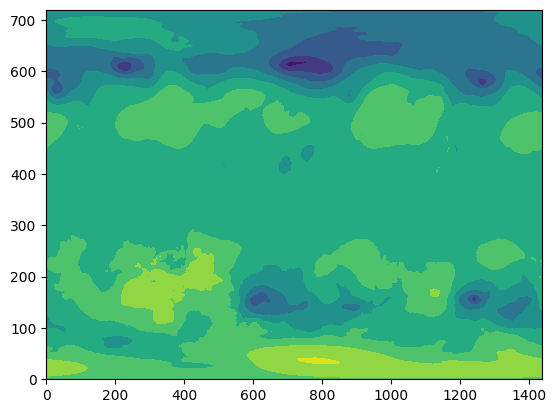

In [44]:
t_era5 = data_era5['mean_sea_level_pressure']
t_era5

plt.contourf(t_era5[0,:,:])

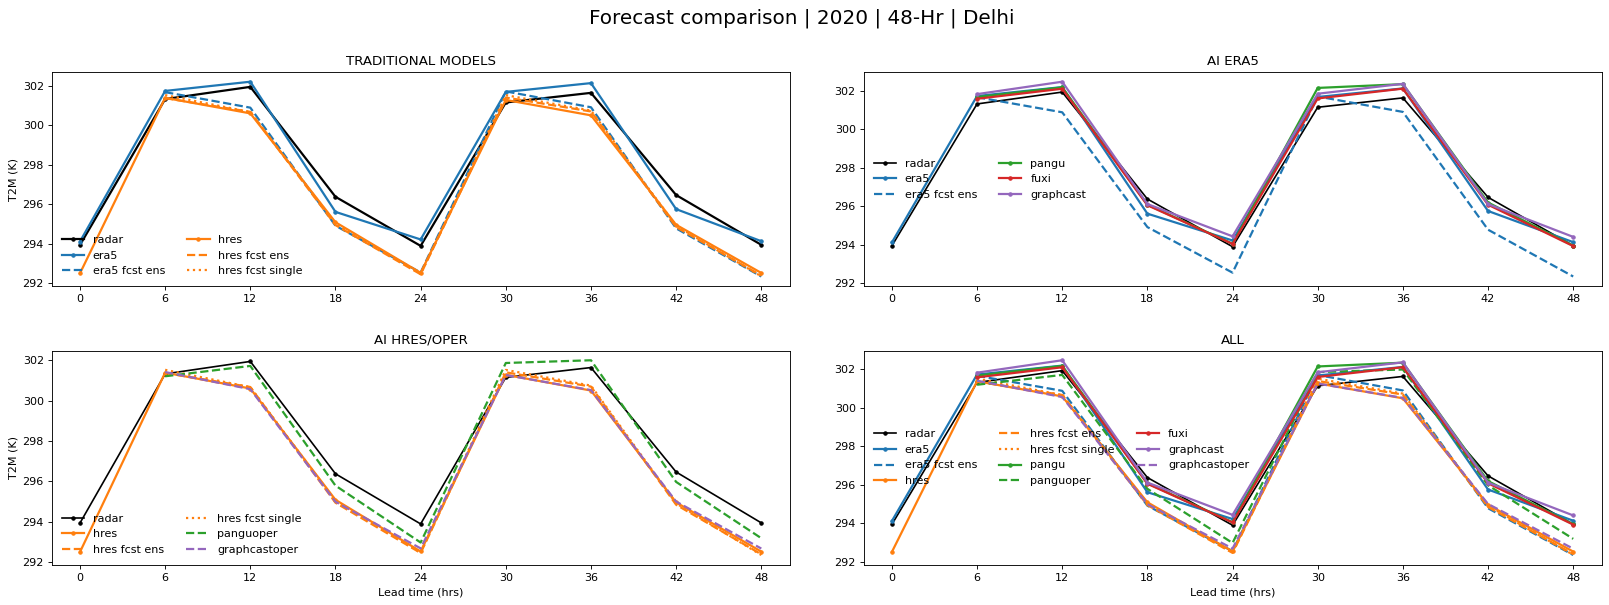

In [22]:
# Forcast metrics computed over a

lw=2
t = np.arange(0,48+6,6)

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')

fig.suptitle('Forecast comparison | 2020 | 48-Hr | Delhi', size=18)

plt.subplot(221)

plt.plot(t,temp_radar_avg, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t, temp_era5_avg, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[1:], temp_era5_fcst_avg, '--', linewidth=lw, color='C0', label='era5 fcst ens')

plt.plot(t, temp_hres_avg, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[1:], temp_hresens_fcst_avg, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[1:], temp_hres_fcst_avg, ':', color='C1', linewidth=lw, label='hres fcst single')

plt.legend(frameon=False, ncol=2)
plt.title('TRADITIONAL MODELS')
plt.ylabel('T2M (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(222)

plt.plot(t,temp_radar_avg, '.-', color='k', label='radar')

plt.plot(t, temp_era5_avg, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[1:], temp_era5_fcst_avg, '--', color='C0', linewidth=lw, label='era5 fcst ens')

plt.plot(t[1:], temp_pangu_avg, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], temp_fuxi_avg, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], temp_graphcast_avg, '.-', color='C4', linewidth=lw, label='graphcast')


plt.legend(frameon=False, ncol=2)
plt.title('AI ERA5')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(223)

plt.plot(t,temp_radar_avg, '.-', color='k', label='radar')

plt.plot(t, temp_hres_avg, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[1:], temp_hresens_fcst_avg, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[1:], temp_hres_fcst_avg, ':', color='C1', linewidth=lw, label='hres fcst single')


plt.plot(t[1:], temp_panguoper_avg, '--', color='C2', linewidth=lw, label='panguoper')
plt.plot(t[1:], temp_graphcastoper_avg, '--', color='C4', linewidth=lw, label='graphcastoper')


plt.legend(frameon=False, ncol=2)
plt.title('AI HRES/OPER')
plt.xlabel('Lead time (hrs)')
plt.ylabel('T2M (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(224)

plt.plot(t,temp_radar_avg, '.-', color='k', label='radar')

plt.plot(t, temp_era5_avg, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[1:], temp_era5_fcst_avg, '--', linewidth=lw, color='C0', label='era5 fcst ens')

plt.plot(t, temp_hres_avg, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[1:], temp_hresens_fcst_avg, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[1:], temp_hres_fcst_avg, ':', color='C1', linewidth=lw, label='hres fcst single')

plt.plot(t[1:], temp_pangu_avg, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], temp_panguoper_avg, '--', color='C2', linewidth=lw, label='panguoper')
plt.plot(t[1:], temp_fuxi_avg, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], temp_graphcast_avg, '.-', color='C4', linewidth=lw, label='graphcast')
plt.plot(t[1:], temp_graphcastoper_avg, '--', color='C4', linewidth=lw, label='graphcastoper')

plt.xlabel('Lead time (hrs)')


plt.legend(frameon=False, ncol=3)
plt.title('ALL')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))

plt.subplots_adjust(hspace=0.3, wspace=0.1)

#plt.savefig('drive/MyDrive/makdi/t2m_comparison_yearly2020_madras.png', bbox_inches='tight')

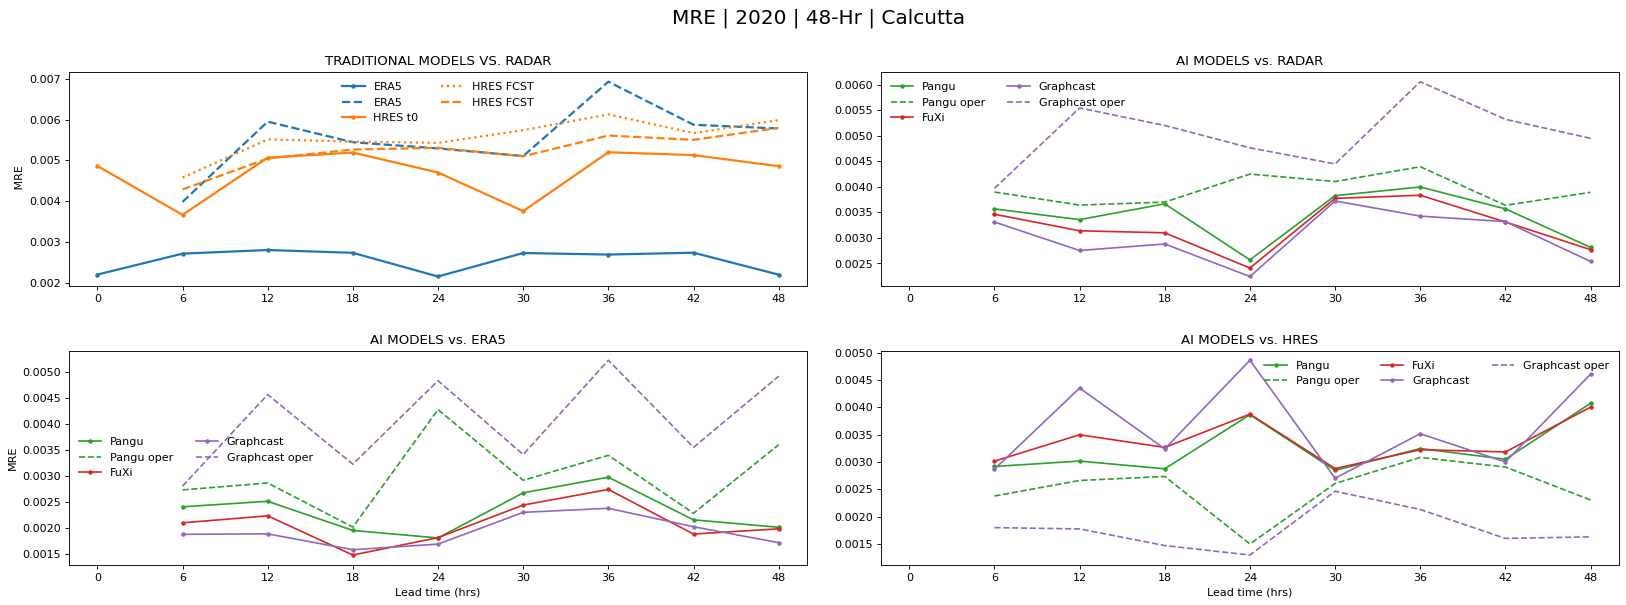

In [ ]:
# MRE comparison for year-long averages

lw=2
t = np.arange(0,48+6,6)

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')

fig.suptitle('MRE | 2020 | 48-Hr | Calcutta', size=18)

plt.subplot(221)

plt.plot(t,mre_era5_radar, '.-', color='C0', linewidth=lw, label='ERA5')
plt.plot(t[1:],mre_era5fcst_radar, '--', color='C0', linewidth=lw, label='ERA5 FCST')
plt.plot(t,mre_hres_radar, '.-', color='C1', linewidth=lw, label='HRES t0')
plt.plot(t[1:],mre_hresfcst_radar, ':', color='C1', linewidth=lw, label='HRES FCST')
plt.plot(t[1:],mre_hresensfcst_radar, '--', color='C1', linewidth=lw, label='HRES ENS FCST')

plt.legend(frameon=False, ncol=2)
plt.title('TRADITIONAL MODELS VS. RADAR')
plt.ylabel(' MRE')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(222)

plt.plot(t[1:],mre_pangu_radar, '.-', color='C2', label='Pangu')
plt.plot(t[1:],mre_panguoper_radar, '--', color='C2', label='Pangu oper')

plt.plot(t[1:],mre_fuxi_radar, '.-', color='C3', label='FuXi')

plt.plot(t[1:],mre_graphcast_radar, '.-', color='C4', label='Graphcast')
plt.plot(t[1:],mre_graphcastoper_radar, '--', color='C4', label='Graphcast oper')

plt.legend(frameon=False, ncol=2)
plt.title('AI MODELS vs. RADAR')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(223)

plt.plot(t[1:],mre_pangu_era5, '.-', color='C2', label='Pangu')
plt.plot(t[1:],mre_panguoper_era5, '--', color='C2', label='Pangu oper')

plt.plot(t[1:],mre_fuxi_era5, '.-', color='C3', label='FuXi')

plt.plot(t[1:],mre_graphcast_era5, '.-', color='C4', label='Graphcast')
plt.plot(t[1:],mre_graphcastoper_era5, '--', color='C4', label='Graphcast oper')


plt.legend(frameon=False, ncol=2)
plt.title('AI MODELS vs. ERA5')
plt.xlabel('Lead time (hrs)')
plt.ylabel('MRE')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(224)

plt.plot(t[1:],mre_pangu_hres, '.-', color='C2', label='Pangu')
plt.plot(t[1:],mre_panguoper_hres, '--', color='C2', label='Pangu oper')

plt.plot(t[1:],mre_fuxi_hres, '.-', color='C3', label='FuXi')

plt.plot(t[1:],mre_graphcast_hres, '.-', color='C4', label='Graphcast')
plt.plot(t[1:],mre_graphcastoper_hres, '--', color='C4', label='Graphcast oper')

plt.xlabel('Lead time (hrs)')


plt.legend(frameon=False, ncol=3)
plt.title('AI MODELS vs. HRES')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))

plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.savefig('drive/MyDrive/makdi/mre_yearly2020_calcutta.png', bbox_inches='tight')

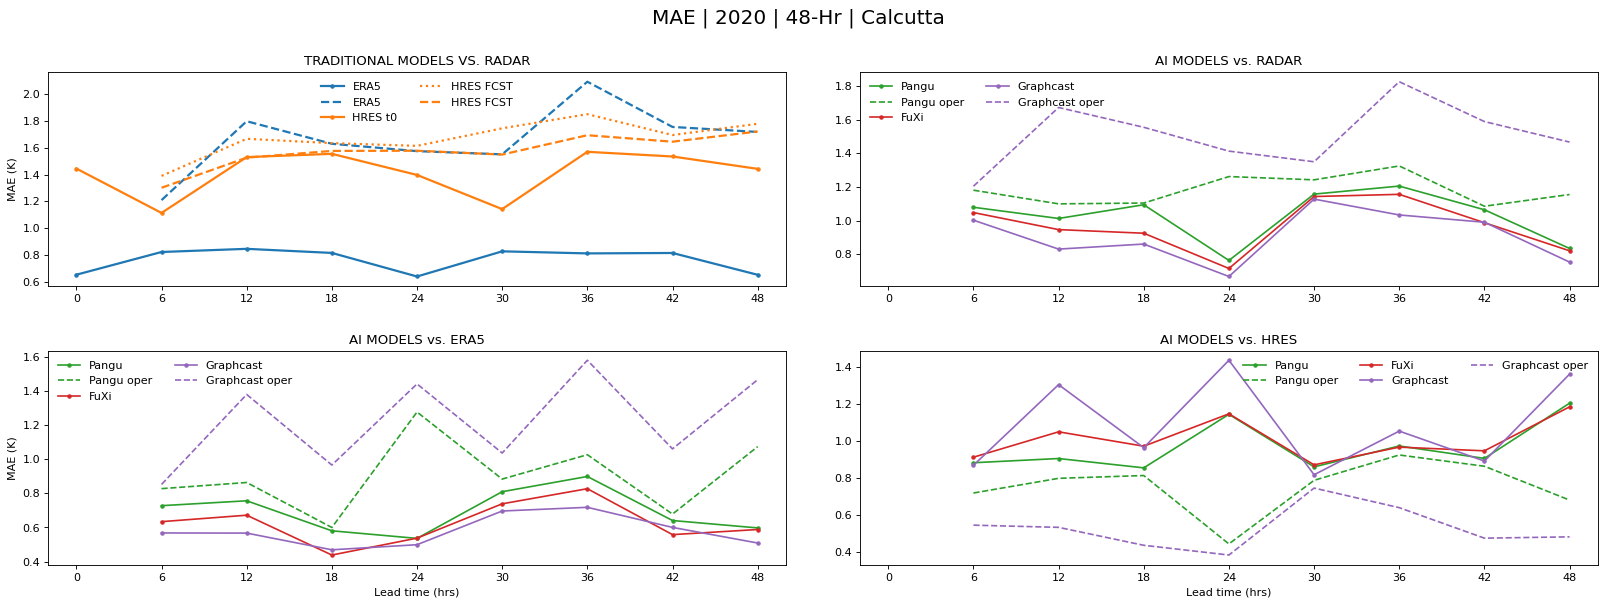

In [ ]:
# Absolute MAE comparison for year-long averages

lw=2
t = np.arange(0,48+6,6)

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')

fig.suptitle('MAE | 2020 | 48-Hr | Calcutta', size=18)

plt.subplot(221)

plt.plot(t,mae_era5_radar, '.-', color='C0', linewidth=lw, label='ERA5')
plt.plot(t[1:],mae_era5fcst_radar, '--', color='C0', linewidth=lw, label='ERA5 FCST')
plt.plot(t,mae_hres_radar, '.-', color='C1', linewidth=lw, label='HRES t0')
plt.plot(t[1:],mae_hresfcst_radar, ':', color='C1', linewidth=lw, label='HRES FCST')
plt.plot(t[1:],mae_hresensfcst_radar, '--', color='C1', linewidth=lw, label='HRES ENS FCST')

plt.legend(frameon=False, ncol=2)
plt.title('TRADITIONAL MODELS VS. RADAR')
plt.ylabel('MAE (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(222)

plt.plot(t[1:],mae_pangu_radar, '.-', color='C2', label='Pangu')
plt.plot(t[1:],mae_panguoper_radar, '--', color='C2', label='Pangu oper')

plt.plot(t[1:],mae_fuxi_radar, '.-', color='C3', label='FuXi')

plt.plot(t[1:],mae_graphcast_radar, '.-', color='C4', label='Graphcast')
plt.plot(t[1:],mae_graphcastoper_radar, '--', color='C4', label='Graphcast oper')

plt.legend(frameon=False, ncol=2)
plt.title('AI MODELS vs. RADAR')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(223)

plt.plot(t[1:],mae_pangu_era5, '.-', color='C2', label='Pangu')
plt.plot(t[1:],mae_panguoper_era5, '--', color='C2', label='Pangu oper')

plt.plot(t[1:],mae_fuxi_era5, '.-', color='C3', label='FuXi')

plt.plot(t[1:],mae_graphcast_era5, '.-', color='C4', label='Graphcast')
plt.plot(t[1:],mae_graphcastoper_era5, '--', color='C4', label='Graphcast oper')


plt.legend(frameon=False, ncol=2)
plt.title('AI MODELS vs. ERA5')
plt.xlabel('Lead time (hrs)')
plt.ylabel('MAE (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(224)

plt.plot(t[1:],mae_pangu_hres, '.-', color='C2', label='Pangu')
plt.plot(t[1:],mae_panguoper_hres, '--', color='C2', label='Pangu oper')

plt.plot(t[1:],mae_fuxi_hres, '.-', color='C3', label='FuXi')

plt.plot(t[1:],mae_graphcast_hres, '.-', color='C4', label='Graphcast')
plt.plot(t[1:],mae_graphcastoper_hres, '--', color='C4', label='Graphcast oper')

plt.xlabel('Lead time (hrs)')


plt.legend(frameon=False, ncol=3)
plt.title('AI MODELS vs. HRES')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))

plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.savefig('drive/MyDrive/makdi/mae_yearly2020_calcutta.png', bbox_inches='tight')

# Year averaged global maps

In [ ]:
# run the cell towards the beginning with all the file sources
#temp_radar_avg         = 0.
temp_era5_avg          = 0.
temp_hres_avg          = 0.
temp_hres_fcst_avg     = 0.
temp_hresens_fcst_avg  = 0.
temp_pangu_avg         = 0.
temp_panguoper_avg     = 0.
temp_fuxi_avg          = 0.
temp_graphcast_avg     = 0.
temp_graphcastoper_avg = 0.
temp_era5_fcst_avg     = 0.

# ========= MAE ============
# === Traditional ========
#mae_era5_radar = 0.
#mae_hres_radar = 0.
#mae_era5fcst_radar = 0.
#mae_hresfcst_radar = 0.
#mae_hresensfcst_radar = 0.

# ====== AI NWP ==========
mae_pangu_era5  = 0.
mae_pangu_hres  = 0.
#mae_pangu_radar = 0.

mae_panguoper_era5  = 0.
mae_panguoper_hres  = 0.
#mae_panguoper_radar = 0.

mae_graphcast_era5  = 0.
mae_graphcast_hres  = 0.
#mae_graphcast_radar = 0.

mae_graphcastoper_era5  = 0.
mae_graphcastoper_hres  = 0.
#mae_graphcastoper_radar = 0.

mae_fuxi_era5  = 0.
mae_fuxi_hres  = 0.
#mae_fuxi_radar = 0.


# ========= MRE ===========
# === Traditional ========
#mre_era5_radar = 0.
#mre_hres_radar = 0.
#mre_era5fcst_radar = 0.
#mre_hresfcst_radar = 0.
#mre_hresensfcst_radar = 0.

# ====== AI NWP ==========
mre_pangu_era5  = 0.
mre_pangu_hres  = 0.
#mre_pangu_radar = 0.

mre_panguoper_era5  = 0.
mre_panguoper_hres  = 0.
#mre_panguoper_radar = 0.

mre_graphcast_era5  = 0.
mre_graphcast_hres  = 0.
#mre_graphcast_radar = 0.

mre_graphcastoper_era5  = 0.
mre_graphcastoper_hres  = 0.
#mre_graphcastoper_radar = 0.

mre_fuxi_era5  = 0.
mre_fuxi_hres  = 0.
#mre_fuxi_radar = 0.


initdate = datetime(2020,1,1,0,0,0)
p1=0
p2=8 # 20 | 8 for 48 hours

v = np.arange(0,12*702,48) # FuXi is only till 16 December. Ugh. Use 700 instead of 732
#v = np.arange(0,12*702,120)
#v = np.arange(0,732,48)
N = len(v)
#v = np.arange(0,12,12)
for i in v:
  print(i)
  date = initdate + timedelta(hours=int(i))

  start = date
  end   = date + timedelta(hours=48) # 48 # 120

  # for weatherbench
  time1=f'{start.year}-{str(start.month).zfill(2)}-{str(start.day).zfill(2)}T{str(start.hour).zfill(2)}:00:00.000000000'
  time2=f'{end.year}-{str(end.month).zfill(2)}-{str(end.day).zfill(2)}T{str(end.hour).zfill(2)}:00:00.000000000'

  data_era5          = ds_era5.sel(time=slice(time1, time2))
  data_hres          = ds_hres.sel(time=slice(time1, time2))
  # --------------------------------------------------------------------
  data_pangu         = ds_pangu.sel(time=slice(time1, time1))
  data_graphcast     = ds_graphcast.sel(time=slice(time1, time1))
  data_fuxi          = ds_fuxi.sel(time=slice(time1, time1))
  # --------------------------------------------------------------------
  data_panguoper     = ds_panguoper.sel(time=slice(time1, time1))
  data_graphcastoper = ds_graphcastoper.sel(time=slice(time1, time1))
  # --------------------------------------------------------------------
  data_ifshres_fcst  = ds_ifshres_fcst.sel(time=slice(time1, time1))
  data_ifsens_fcst   = ds_ifsens_fcst.sel(time=slice(time1, time1))
  data_era5_fcst     = ds_era5_fcst.sel(time=slice(time1, time1))

  if i == 0:
    lat1 = data_era5['latitude'].values
    lat2 = data_hres['latitude'].values
    lon = data_era5['longitude'].values

  #p_era5 = data_era5['level'].values
  t_era5 = data_era5['2m_temperature'].values
  #u_era5 = data_era5['10m_u_component_of_wind']
  #v_era5 = data_era5['10m_v_component_of_wind']

  #p_hres = data_hres['level'].values
  t_hres = data_hres['2m_temperature'].values
  #u_hres = data_hres['10m_u_component_of_wind'].values
  #v_hres = data_hres['10m_v_component_of_wind'].values

  #p_pangu = data_pangu['level'].values
  t_pangu = data_pangu['2m_temperature'][0,p1:p2,:,:].values
  #u_pangu = data_pangu['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_pangu = data_pangu['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_graphcast = data_graphcast['level'].values
  t_graphcast = data_graphcast['2m_temperature'][0,p1:p2,:,:].values
  #u_graphcast = data_graphcast['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_graphcast = data_graphcast['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_fuxi = data_fuxi['level'].values
  t_fuxi = data_fuxi['2m_temperature'][0,p1:p2,:,:].values
  #u_fuxi = data_fuxi['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_fuxi = data_fuxi['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_panguoper = data_panguoper['level'].values
  t_panguoper = data_panguoper['2m_temperature'][0,p1:p2,:,:].values
  #u_panguoper = data_panguoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_panguoper = data_panguoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
  #u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_ifshres_fcst  = data_ifshres_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
  #u_ifshres_fcst  = data_ifshres_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_ifshres_fcst  = data_ifshres_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_ifsens_fcst   = data_ifsens_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
  #u_ifsens_fcst   = data_ifsens_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_ifsens_fcst   = data_ifsens_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_era5_fcst     = data_era5_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values # since it starts from 0
  #u_era5_fcst     = data_era5_fcst['10m_u_component_of_wind'][0,p1+1:p2+1,:,:].values
  #v_era5_fcst     = data_era5_fcst['10m_v_component_of_wind'][0,p1+1:p2+1,:,:].values

  # improve the interp function for accuracy gains
  #print(f'{t_era5[:,iy1_desc,ix1].shape}')
  temp_era5          = np.flip(t_era5, axis=1)
  temp_hres          = t_hres
  temp_hres_fcst     = t_ifshres_fcst
  temp_hresens_fcst  = t_ifsens_fcst
  temp_pangu         = np.flip(t_pangu, axis=1)
  temp_panguoper     = np.flip(t_panguoper, axis=1)
  temp_fuxi          = t_fuxi
  temp_graphcast     = t_graphcast
  temp_graphcastoper = t_graphcastoper
  temp_era5_fcst     = t_era5_fcst

  #print(f'{temp_radar.shape=}')
  #print(f'{temp_hres.shape=}')
  #print(f'{temp_pangu.shape=}')
  #print(f'{temp_era5_fcst.shape=}')

  # All data loaded and interpolated
  #temp_radar_avg         += temp_radar/N
  temp_era5_avg          += temp_era5/N
  temp_hres_avg          += temp_hres/N
  temp_hres_fcst_avg     += temp_hres_fcst/N
  temp_hresens_fcst_avg  += temp_hresens_fcst/N
  temp_pangu_avg         += temp_pangu/N
  temp_panguoper_avg     += temp_panguoper/N
  temp_fuxi_avg          += temp_fuxi/N
  temp_graphcast_avg     += temp_graphcast/N
  temp_graphcastoper_avg += temp_graphcastoper/N
  temp_era5_fcst_avg     += temp_era5_fcst/N


  # ================== MAE ========================================================
  # groud truth
  #mae_era5_radar += np.abs(temp_era5 - temp_radar)/N
  #mae_hres_radar += np.abs(temp_hres - temp_radar)/N

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  #mae_era5fcst_radar    += np.abs(temp_era5_fcst - temp_radar[1:,:,:])/N
  #mae_hresfcst_radar    += np.abs(temp_hres_fcst - temp_radar[1:,:,:])/N
  #mae_hresensfcst_radar += np.abs(temp_hresens_fcst - temp_radar[1:,:,:])/N

  mae_pangu_era5  += np.abs(temp_pangu - temp_era5[1:,:,:])/N
  mae_pangu_hres  += np.abs(temp_pangu - temp_hres[1:,:,:])/N
  #mae_pangu_radar += np.abs(temp_pangu - temp_radar[1:,:,:])/N

  mae_panguoper_era5  += np.abs(temp_panguoper - temp_era5[1:,:,:])/N
  mae_panguoper_hres  += np.abs(temp_panguoper - temp_hres[1:,:,:])/N
  #mae_panguoper_radar += np.abs(temp_panguoper - temp_radar[1:,:,:])/N

  mae_graphcast_era5  += np.abs(temp_graphcast - temp_era5[1:,:,:])/N
  mae_graphcast_hres  += np.abs(temp_graphcast - temp_hres[1:,:,:])/N
  #mae_graphcast_radar += np.abs(temp_graphcast - temp_radar[1:,:,:])/N

  mae_graphcastoper_era5  += np.abs(temp_graphcastoper - temp_era5[1:,:,:])/N
  mae_graphcastoper_hres  += np.abs(temp_graphcastoper - temp_hres[1:,:,:])/N
  #mae_graphcastoper_radar += np.abs(temp_graphcastoper - temp_radar[1:,:,:])/N

  mae_fuxi_era5  += np.abs(temp_fuxi - temp_era5[1:,:,:])/N
  mae_fuxi_hres  += np.abs(temp_fuxi - temp_hres[1:,:,:])/N
  #mae_fuxi_radar += np.abs(temp_fuxi - temp_radar[1:,:,:])/N


  # ================== RMAE ========================================================
  # groud truth
  #mre_era5_radar += np.abs(temp_era5 - temp_radar)/(N*temp_radar)
  #mre_hres_radar += np.abs(temp_hres - temp_radar)/(N*temp_radar)

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  #mre_era5fcst_radar    += np.abs(temp_era5_fcst - temp_radar[1:])/(N*temp_radar[1:])
  #mre_hresfcst_radar    += np.abs(temp_hres_fcst - temp_radar[1:])/(N*temp_radar[1:])
  #mre_hresensfcst_radar += np.abs(temp_hresens_fcst - temp_radar[1:])/(N*temp_radar[1:])

  mre_pangu_era5  += np.abs(temp_pangu - temp_era5[1:,:,:])/(N*temp_era5[1:])
  mre_pangu_hres  += np.abs(temp_pangu - temp_hres[1:,:,:])/(N*temp_hres[1:])
  #mre_pangu_radar += np.abs(temp_pangu - temp_radar[1:,:,:])/(N*temp_radar[1:])

  mre_panguoper_era5  += np.abs(temp_panguoper - temp_era5[1:,:,:])/(N*temp_era5[1:,:,:])
  mre_panguoper_hres  += np.abs(temp_panguoper - temp_hres[1:,:,:])/(N*temp_hres[1:,:,:])
  #mre_panguoper_radar += np.abs(temp_panguoper - temp_radar[1:,:,:])/(N*temp_radar[1:,:,:])

  mre_graphcast_era5  += np.abs(temp_graphcast - temp_era5[1:,:,:])/(N*temp_era5[1:,:,:])
  mre_graphcast_hres  += np.abs(temp_graphcast - temp_hres[1:,:,:])/(N*temp_hres[1:,:,:])
  #mre_graphcast_radar += np.abs(temp_graphcast - temp_radar[1:])/(N*temp_radar[1:])

  mre_graphcastoper_era5  += np.abs(temp_graphcastoper - temp_era5[1:,:,:])/(N*temp_era5[1:,:,:])
  mre_graphcastoper_hres  += np.abs(temp_graphcastoper - temp_hres[1:,:,:])/(N*temp_hres[1:,:,:])
  #mre_graphcastoper_radar += np.abs(temp_graphcastoper - temp_radar[1:])/(N*temp_radar[1:])

  mre_fuxi_era5  += np.abs(temp_fuxi - temp_era5[1:,:,:])/(N*temp_era5[1:,:,:])
  mre_fuxi_hres  += np.abs(temp_fuxi - temp_hres[1:,:,:])/(N*temp_hres[1:,:,:])
  #mre_fuxi_radar += np.abs(temp_fuxi - temp_radar[1:])/(N*temp_radar[1:])


0
48
96
144
192
240
288
336
384
432
480
528
576
624
672
720
768
816
864
912
960
1008
1056
1104
1152
1200
1248
1296
1344
1392
1440
1488
1536
1584
1632
1680
1728
1776
1824
1872
1920
1968
2016
2064
2112
2160
2208
2256
2304
2352
2400
2448
2496
2544
2592
2640
2688
2736
2784
2832
2880
2928
2976
3024
3072
3120
3168
3216
3264
3312
3360
3408
3456
3504
3552
3600
3648
3696
3744
3792
3840
3888
3936
3984
4032
4080
4128
4176
4224
4272
4320
4368
4416
4464
4512
4560
4608
4656
4704
4752
4800
4848
4896
4944
4992
5040
5088
5136
5184
5232
5280
5328
5376
5424
5472
5520
5568
5616
5664
5712
5760
5808
5856
5904
5952
6000
6048
6096
6144
6192
6240
6288
6336
6384
6432
6480
6528
6576
6624
6672
6720
6768
6816
6864
6912
6960
7008
7056
7104
7152
7200
7248
7296
7344
7392
7440
7488
7536
7584
7632
7680
7728
7776
7824
7872
7920
7968
8016
8064
8112
8160
8208
8256
8304
8352
8400


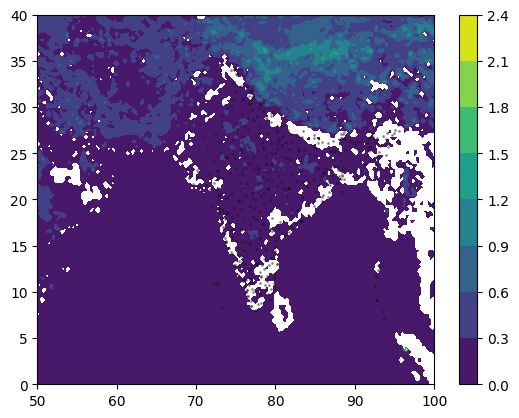

In [ ]:
#levs=1.5*np.arange(-1,1.1,0.1)
#diff = mre_fuxi_era5[7,:,:] - mre_fuxi_era5[0,:,:]
#diff = mae_pangu_era5[7,:,:] - mae_pangu_era5[0,:,:]
diff = mae_graphcast_era5[7,:,:] - mae_graphcast_era5[0,:,:]
diff[diff < 0] = np.nan
#plt.contourf(lon,lat2,mae_fuxi_era5[19,:,:] - mae_fuxi_era5[1,:,:], levels=levs, extend='both')
plt.contourf(lon,lat2,diff)#, levels=levs, extend='both')
plt.colorbar()
#plt.clim(0,2)
plt.xlim(50,100)
plt.ylim(0,40)

stations = Stations()
stations_list = stations.region('IN')

for i in np.arange(0,stations_list.count()):
  y = stations_list.fetch()['latitude'][i]
  x = stations_list.fetch()['longitude'][i]
  plt.plot(x,y, marker='o', markeredgecolor='k', alpha=0.4, markersize=1)

In [ ]:
lon[200:401]
lat2[380:500]

array([ 5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,
        7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,
        9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 ,
       11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75,
       14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  ,
       16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75, 18.  , 18.25,
       18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  , 20.25, 20.5 ,
       20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25, 22.5 , 22.75,
       23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 , 24.75, 25.  ,
       25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75, 27.  , 27.25,
       27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  , 29.25, 29.5 ,
       29.75, 30.  , 30.25, 30.5 , 30.75, 31.  , 31.25, 31.5 , 31.75,
       32.  , 32.25, 32.5 , 32.75, 33.  , 33.25, 33.5 , 33.75, 34.  ,
       34.25, 34.5 , 34.75], dtype=float32)

In [ ]:
lat1 = data_era5['latitude'].values
lat2 = data_hres['latitude'].values
lon = data_era5['longitude'].values

In [ ]:
stations_list = stations.region('IN')

for i in np.arange(0,stations_list.count()):
  lat = stations_list.fetch()['latitude'][i]
  lon = stations_list.fetch()['longitude'][i]
  axs[0].plot(lon,lat, marker='o', markersize=2)


In [ ]:
y

np.float64(83.2333)

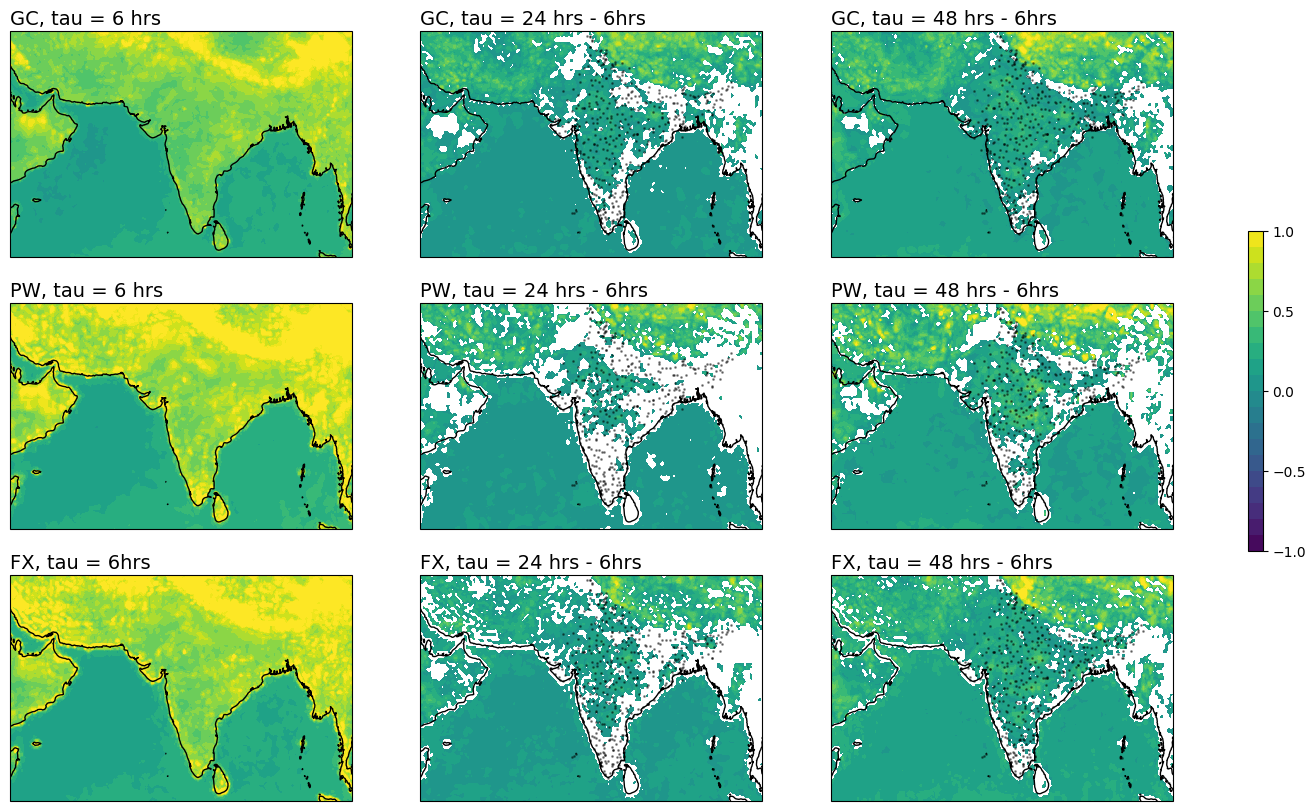

In [ ]:
stations = Stations()
stations_list = stations.region('IN')

fig, axs = plt.subplots(nrows=3,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,10))


axs=axs.flatten()

x1=200
x2=401

y1=380
y2=500

msz=1
alp=0.4

levs = 1*np.arange(-1,1.1,0.1)

axs[0].coastlines()
axs[0].set_aspect('auto')
#newcmap='RdYlBu_r'
cs=axs[0].contourf(lon[x1:x2],lat2[y1:y2],mae_graphcast_era5[0,y1:y2,x1:x2],transform = ccrs.PlateCarree(), levels=levs,extend='both')
# colorbar
#cbar_ax = fig.add_axes([0.49, 0.56, 0.01, 0.32])
#cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical', ticks=np.array([-30,-15,0,15,30]), extendrect='True', extendfrac=0)

#axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=["x", "y", "bottom", "left"], linewidth=1, color='gray', alpha=0.5, linestyle=':', ylocs=np.array([15,30,45,60,75]))
#axs[0].set_extent([-180, 180, 0, 80], crs=ccrs.PlateCarree())
axs[0].set_title(r"GC, tau = 6 hrs", fontsize=14, loc='left', pad=5)


axs[1].coastlines()
axs[1].set_aspect('auto')
diff = mae_graphcast_era5[3,:,:] - mae_graphcast_era5[0,:,:]
diff[diff < 0] = np.nan
for i in np.arange(0,stations_list.count()):
  y = stations_list.fetch()['latitude'][i]
  x = stations_list.fetch()['longitude'][i]
  axs[1].plot(x,y, marker='o',  color='k', alpha=alp, markersize=msz)

cs=axs[1].contourf(lon[x1:x2],lat2[y1:y2],diff[y1:y2,x1:x2],transform = ccrs.PlateCarree(), levels=levs,extend='both')
axs[1].set_title(r"GC, tau = 24 hrs - 6hrs", fontsize=14, loc='left', pad=5)


axs[2].coastlines()
axs[2].set_aspect('auto')
diff = mae_graphcast_era5[7,:,:] - mae_graphcast_era5[0,:,:]
diff[diff < 0] = np.nan
cs=axs[2].contourf(lon[x1:x2],lat2[y1:y2],diff[y1:y2,x1:x2],transform = ccrs.PlateCarree(), levels=levs,extend='both')
axs[2].set_title(r"GC, tau = 48 hrs - 6hrs", fontsize=14, loc='left', pad=5)
for i in np.arange(0,stations_list.count()):
  y = stations_list.fetch()['latitude'][i]
  x = stations_list.fetch()['longitude'][i]
  axs[2].plot(x,y, marker='o',  color='k', alpha=alp, markersize=msz)



# ============================================================================
axs[3].coastlines()
axs[3].set_aspect('auto')
newcmap='RdYlBu_r'
cs=axs[3].contourf(lon[x1:x2],lat2[y1:y2],mae_pangu_era5[0,y1:y2,x1:x2],transform = ccrs.PlateCarree(), levels=levs,extend='both')
axs[3].set_title(r"PW, tau = 6 hrs", fontsize=14, loc='left', pad=5)



# colorbar
cbar_ax = fig.add_axes([0.95, 0.36, 0.01, 0.32])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical', ticks=np.array([-1,-0.5,0,0.5,1]), extendrect='True', extendfrac=0)

#axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=["x", "y", "bottom", "left"], linewidth=1, color='gray', alpha=0.5, linestyle=':', ylocs=np.array([15,30,45,60,75]))
#axs[0].set_extent([-180, 180, 0, 80], crs=ccrs.PlateCarree())
#axs[0].set_title(r"NH, DJF | -$u'\omega'$ (1000*m Pa/$s^2$)", fontsize=14, loc='left', pad=5)

axs[4].coastlines()
axs[4].set_aspect('auto')
diff = mae_pangu_era5[3,:,:] - mae_pangu_era5[0,:,:]
diff[diff < 0] = np.nan
cs=axs[4].contourf(lon[x1:x2],lat2[y1:y2],diff[y1:y2,x1:x2],transform = ccrs.PlateCarree(), levels=levs,extend='both')
axs[4].set_title(r"PW, tau = 24 hrs - 6hrs", fontsize=14, loc='left', pad=5)
for i in np.arange(0,stations_list.count()):
  y = stations_list.fetch()['latitude'][i]
  x = stations_list.fetch()['longitude'][i]
  axs[4].plot(x,y, marker='o', color='k', alpha=alp, markersize=msz)



axs[5].coastlines()
axs[5].set_aspect('auto')
diff = mae_pangu_era5[7,:,:] - mae_pangu_era5[0,:,:]
diff[diff < 0] = np.nan
cs=axs[5].contourf(lon[x1:x2],lat2[y1:y2],diff[y1:y2,x1:x2],transform = ccrs.PlateCarree(), levels=levs,extend='both')
axs[5].set_title(r"PW, tau = 48 hrs - 6hrs", fontsize=14, loc='left', pad=5)
for i in np.arange(0,stations_list.count()):
  y = stations_list.fetch()['latitude'][i]
  x = stations_list.fetch()['longitude'][i]
  axs[5].plot(x,y, marker='o',  color='k', alpha=alp, markersize=msz)


# ============================================================================
axs[6].coastlines()
axs[6].set_aspect('auto')
newcmap='RdYlBu_r'
cs=axs[6].contourf(lon[x1:x2],lat2[y1:y2],mae_fuxi_era5[0,y1:y2,x1:x2],transform = ccrs.PlateCarree(), levels=levs,extend='both')
axs[6].set_title(r"FX, tau = 6hrs", fontsize=14, loc='left', pad=5)

# colorbar
#cbar_ax = fig.add_axes([0.49, 0.56, 0.01, 0.32])
#cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical', ticks=np.array([-30,-15,0,15,30]), extendrect='True', extendfrac=0)

#axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=["x", "y", "bottom", "left"], linewidth=1, color='gray', alpha=0.5, linestyle=':', ylocs=np.array([15,30,45,60,75]))
#axs[0].set_extent([-180, 180, 0, 80], crs=ccrs.PlateCarree())
#axs[0].set_title(r"NH, DJF | -$u'\omega'$ (1000*m Pa/$s^2$)", fontsize=14, loc='left', pad=5)

axs[7].coastlines()
axs[7].set_aspect('auto')
diff = mae_fuxi_era5[3,:,:] - mae_fuxi_era5[0,:,:]
diff[diff < 0] = np.nan
cs=axs[7].contourf(lon[x1:x2],lat2[y1:y2],diff[y1:y2,x1:x2],transform = ccrs.PlateCarree(), levels=levs,extend='both')
axs[7].set_title(r"FX, tau = 24 hrs - 6hrs", fontsize=14, loc='left', pad=5)
for i in np.arange(0,stations_list.count()):
  y = stations_list.fetch()['latitude'][i]
  x = stations_list.fetch()['longitude'][i]
  axs[7].plot(x,y, marker='o', color='k', alpha=alp, markersize=msz)


axs[8].coastlines()
axs[8].set_aspect('auto')
diff = mae_fuxi_era5[7,:,:] - mae_fuxi_era5[0,:,:]
diff[diff < 0] = np.nan
cs=axs[8].contourf(lon[x1:x2],lat2[y1:y2],diff[y1:y2,x1:x2],transform = ccrs.PlateCarree(), levels=levs,extend='both')
axs[8].set_title(r"FX, tau = 48 hrs - 6hrs", fontsize=14, loc='left', pad=5)
for i in np.arange(0,stations_list.count()):
  y = stations_list.fetch()['latitude'][i]
  x = stations_list.fetch()['longitude'][i]
  axs[8].plot(x,y, marker='o', color='k', alpha=alp, markersize=msz)

plt.savefig('drive/MyDrive/makdi/mae_yearly2020_india.png', bbox_inches='tight')

(0.0, 40.0)

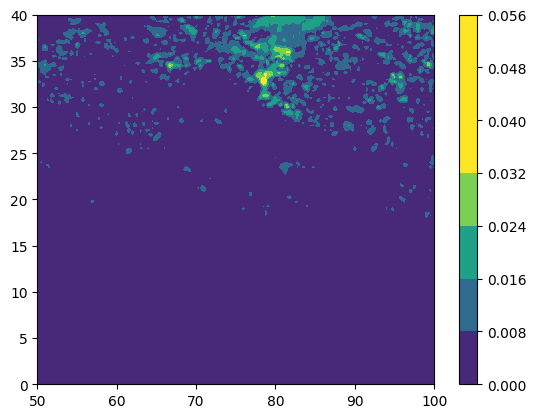

In [ ]:
plt.contourf(lon,lat2,mre_fuxi_era5[7,:,:])
plt.colorbar()
#plt.clim(0.01,0.03)
plt.clim(0,0.035)
plt.xlim(50,100)
plt.ylim(0,40)

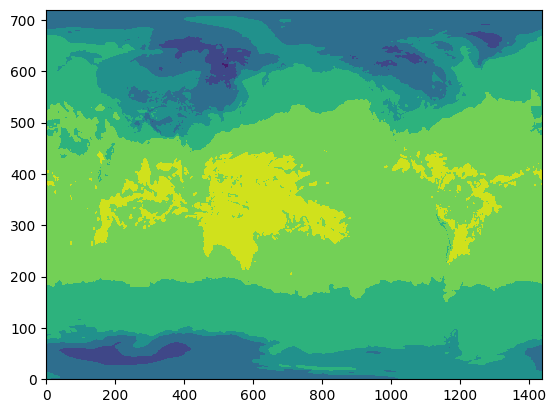

In [ ]:
plt.contourf( np.flip(temp_era5[0,:,:],axis=0) )

# Initial testing: Single day analysis

In [ ]:
# Load radar data

start = datetime(2020,1,1,0,0,0)
end   = datetime(2020,1,5,23,0,0) # 2 to 5 for testing
#end   = datetime(2020,1,6,5,0,0) # might need a 6 hour offset since forecasts from AI models begin at 6 hrs, not 0 hrs.

#start = datetime(2020,5,26,0,0,0)
#end   = datetime(2020,5,27,23,0,0)

# Bhadla solar park
#bhadla = Point(27.5175957,71.9278131)
delhi       = Point(28.6439835,76.9280785)
#bhuj        = Point(23.2420,69.6669) # not complete
madras      = Point(13.0, 80.1833)
agartala    = Point(23.8315, 91.2868)
calcutta    = Point(22.5333, 88.3333)
bhopal      = Point(23.2833, 77.35)

delhi_data       = Hourly(delhi,start,end) # daily
#bhuj_data        = Hourly(bhuj,start,end)
madras_data      = Hourly(madras,start,end)
agartala_data    = Hourly(agartala,start,end)
calcutta_data    = Hourly(calcutta,start,end)
bhopal_data      = Hourly(bhopal,start,end)

delhi_data       = delhi_data.fetch()
#bhuj_data        = bhuj_data.fetch()
madras_data      = madras_data.fetch()
agartala_data    = agartala_data.fetch()
calcutta_data    = calcutta_data.fetch()
bhopal_data      = bhopal_data.fetch()

In [ ]:
#delhi_data['temp'][0::6].shape
delhi_data.fetch()['temp'][0::6].shape

(20,)

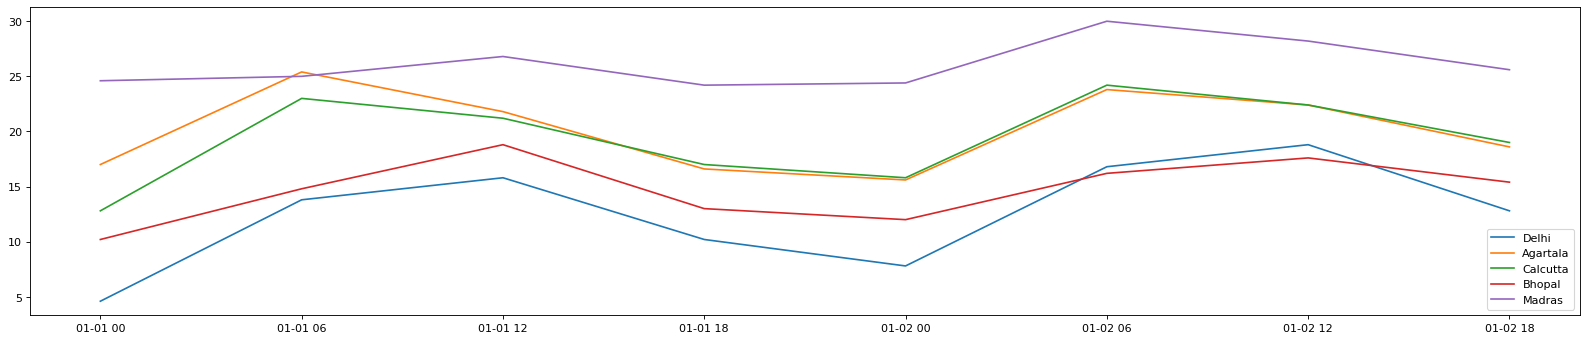

In [ ]:
# Bhopal and Agartala have broken data. Use the other three

fig=plt.figure(figsize=(25, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(delhi_data['temp'][0::6], color='C0', label='Delhi')
plt.plot(agartala_data['temp'][0::6], color='C1', label='Agartala')
plt.plot(calcutta_data['temp'][0::6], color='C2', label='Calcutta')
plt.plot(bhopal_data['temp'][0::6], color='C3', label='Bhopal')
plt.plot(madras_data['temp'][0::6], color='C4', label='Madras')
plt.legend()

In [ ]:
# Loading WeatherBench data
# data guide: https://weatherbench2.readthedocs.io/en/latest/data-guide.html

# Ground truth to compare to
target_path_era5_analysis     = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'
target_path_hres_analysis     = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'

# ============ AI + TRADITIONAL FORECASTS ====================
prediction_path_pangu         = 'gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
prediction_path_graphcast     = 'gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
prediction_path_fuxi          = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'

prediction_path_panguoper     = 'gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
prediction_path_graphcastoper = 'gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'

# traditional model forecasts
prediction_path_ifshres_forecast  = 'gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
prediction_path_ifsens_forecast   = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721_mean.zarr' # can remove "_mean" to get the full ensemble
prediction_path_era5_forecast     = 'gs://weatherbench2/datasets/era5-forecasts/2020-1440x721.zarr'

#prediction_path_neuralgcm    = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'
#prediction_path_sphericalcnn = ''gs://weatherbench2/datasets/sphericalcnn/2020-240x121_equiangular_with_poles.zarr''


In [ ]:
# All datasets available at 6-hourly resolution
time1='2020-01-01T00:00:00.000000000'
time2='2020-01-05T18:00:00.000000000' # 02 to 05 for testing
#time1='2020-05-26T00:00:00.000000000'
#time2='2020-05-27T18:00:00.000000000' # 02 to 05 for testing


ds_era5 = xr.open_zarr(
    target_path_era5_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_hres = xr.open_zarr(
    target_path_hres_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_pangu = xr.open_zarr(
    prediction_path_pangu,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcast = xr.open_zarr(
    prediction_path_graphcast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_fuxi = xr.open_zarr(
    prediction_path_fuxi,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_panguoper = xr.open_zarr(
    prediction_path_panguoper,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcastoper = xr.open_zarr(
    prediction_path_graphcastoper,
    chunks=None,
    storage_options=dict(token='anon'),
)


# traditional
ds_ifshres_fcst = xr.open_zarr(
    prediction_path_ifshres_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_ifsens_fcst = xr.open_zarr(
    prediction_path_ifsens_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_era5_fcst = xr.open_zarr(
    prediction_path_era5_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)

# forecast is made every 6 hours using initial conditions every 12 hours. so time axis has 2 samples per day, but the prediction_delta has 6 samples per timestamp
data_era5          = ds_era5.sel(time=slice(time1, time2))
data_hres          = ds_hres.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_pangu         = ds_pangu.sel(time=slice(time1, time2))
data_graphcast     = ds_graphcast.sel(time=slice(time1, time2))
data_fuxi          = ds_fuxi.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_panguoper     = ds_panguoper.sel(time=slice(time1, time2))
data_graphcastoper = ds_graphcastoper.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_ifshres_fcst  = ds_ifshres_fcst.sel(time=slice(time1, time2))
data_ifsens_fcst   = ds_ifsens_fcst.sel(time=slice(time1, time2))
data_era5_fcst     = ds_era5_fcst.sel(time=slice(time1, time2))

print('Done')

Done


In [ ]:
#data_hres
#data_pangu
#data_graphcast
#data_fuxi

p1=0
p2=20 # 8

lat1 = data_era5['latitude'].values
lat2 = data_hres['latitude'].values
lon = data_era5['longitude'].values

#p_era5 = data_era5['level'].values
t_era5 = data_era5['2m_temperature']
u_era5 = data_era5['10m_u_component_of_wind']
v_era5 = data_era5['10m_v_component_of_wind']

#p_hres = data_hres['level'].values
t_hres = data_hres['2m_temperature'].values
u_hres = data_hres['10m_u_component_of_wind'].values
v_hres = data_hres['10m_v_component_of_wind'].values

#p_pangu = data_pangu['level'].values
t_pangu = data_pangu['2m_temperature'][0,p1:p2,:,:].values
u_pangu = data_pangu['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_pangu = data_pangu['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_graphcast = data_graphcast['level'].values
t_graphcast = data_graphcast['2m_temperature'][0,p1:p2,:,:].values
u_graphcast = data_graphcast['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcast = data_graphcast['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_fuxi = data_fuxi['level'].values
t_fuxi = data_fuxi['2m_temperature'][0,p1:p2,:,:].values
u_fuxi = data_fuxi['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_fuxi = data_fuxi['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_panguoper = data_panguoper['level'].values
t_panguoper = data_panguoper['2m_temperature'][0,p1:p2,:,:].values
u_panguoper = data_panguoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_panguoper = data_panguoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_ifshres_fcst  = data_ifshres_fcst['2m_temperature'][0,p1:p2,:,:].values
u_ifshres_fcst  = data_ifshres_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_ifshres_fcst  = data_ifshres_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_ifsens_fcst   = data_ifsens_fcst['2m_temperature'][0,p1:p2,:,:].values
u_ifsens_fcst   = data_ifsens_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_ifsens_fcst   = data_ifsens_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_era5_fcst     = data_era5_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
u_era5_fcst     = data_era5_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_era5_fcst     = data_era5_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

# example
#t_fuxi.shape

In [ ]:
#data_era5_fcst['2m_temperature'][0,p1+1:p2+1,:,:]
data_ifsens_fcst['2m_temperature'][0,p1+1:p2+1,:,:]
data_ifshres_fcst['2m_temperature'][0,p1+1:p2+1,:,:]

<xarray.DataArray '2m_temperature' (time: 1, prediction_timedelta: 40,
                                    lat: 721, lon: 1440)> Size: 166MB
[41529600 values with dtype=float32]
Coordinates:
  * lat                   (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.75 90.0
  * lon                   (lon) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 320B 06:00:0...
  * time                  (time) datetime64[ns] 8B 2020-01-05T12:00:00

# Data loading complete. Now compare. First compare radar with ERA5 and HRES analysis. Then, compare forecasts over short lead times.


In [ ]:
# interpolating model timeseries to radar locations - linear interpolation from immediate boundaries will suffice for now
from scipy.interpolate import LinearNDInterpolator

#delhi       = Point(28.6439835,76.9280785)
#bhuj        = Point(23.2420,69.6669) # not complete
#madras      = Point(13.0, 80.1833)
#agartala    = Point(23.8315, 91.2868)
#calcutta    = Point(22.5333, 88.3333)
#bhopal      = Point(23.2833, 77.35)

# delhi
lat0=28.6439835
lon0=76.9280785

#madras
#lat0=13.
#lon0=80.1833

# calcutta
#lat0=22.5333
#lon0=88.3333

ix1=len(lon[lon<lon0])-1
ix2=len(lon[lon<lon0])

# ERA5, Pangu, and PanguOpen will use this
iy1_desc=len(lat1[lat1>lat0])-1
iy2_desc=len(lat1[lat1>lat0])

# Rest will use this
iy1_asc=len(lat2[lat2<lat0])-1
iy2_asc=len(lat2[lat2<lat0])


#x=np.array([lat[ix1], lat[ix1], lat[ix2], lat[ix2]])
#y=np.array([lat[iy1], lat[iy2], lat[iy1], lat[iy2]])
#z=np.array([t_era5[iy1], lat[iy2], lat[iy1], lat[iy2]])
#interp = LinearNDInterpolator(list(zip(x, y)), z)
#Z = interp(lon0, lat0)

delhi_era5 = 0.25*(t_era5[:,iy1_desc,ix1] + t_era5[:,iy1_desc,ix2] + t_era5[:,iy2_desc,ix1] + t_era5[:,iy2_desc,ix2])
delhi_hres = 0.25*(t_hres[:,iy1_asc,ix1] + t_hres[:,iy1_asc,ix2] + t_hres[:,iy2_asc,ix1] + t_hres[:,iy2_asc,ix2])
delhi_hres_fcst = 0.25*(t_ifshres_fcst[:,iy1_asc,ix1] + t_ifshres_fcst[:,iy1_asc,ix2] + t_ifshres_fcst[:,iy2_asc,ix1] + t_ifshres_fcst[:,iy2_asc,ix2])
delhi_hresens_fcst = 0.25*(t_ifsens_fcst[:,iy1_asc,ix1] + t_ifsens_fcst[:,iy1_asc,ix2] + t_ifsens_fcst[:,iy2_asc,ix1] + t_ifsens_fcst[:,iy2_asc,ix2])
delhi_pangu = 0.25*(t_pangu[:,iy1_desc,ix1] + t_pangu[:,iy1_desc,ix2] + t_pangu[:,iy2_desc,ix1] + t_pangu[:,iy2_desc,ix2])
delhi_panguoper = 0.25*(t_panguoper[:,iy1_desc,ix1] + t_panguoper[:,iy1_desc,ix2] + t_panguoper[:,iy2_desc,ix1] + t_panguoper[:,iy2_desc,ix2])
delhi_fuxi = 0.25*(t_fuxi[:,iy1_asc,ix1] + t_fuxi[:,iy1_asc,ix2] + t_fuxi[:,iy2_asc,ix1] + t_fuxi[:,iy2_asc,ix2])
delhi_graphcast = 0.25*(t_graphcast[:,iy1_asc,ix1] + t_graphcast[:,iy1_asc,ix2] + t_graphcast[:,iy2_asc,ix1] + t_graphcast[:,iy2_asc,ix2])
delhi_graphcastoper = 0.25*(t_graphcastoper[:,iy1_asc,ix1] + t_graphcastoper[:,iy1_asc,ix2] + t_graphcastoper[:,iy2_asc,ix1] + t_graphcastoper[:,iy2_asc,ix2])
delhi_era5_fcst = 0.25*(t_era5_fcst[:,iy1_asc,ix1] + t_era5_fcst[:,iy1_asc,ix2] + t_era5_fcst[:,iy2_asc,ix1] + t_era5_fcst[:,iy2_asc,ix2])


# Single-day 48 hours and 120 hours lead time testing

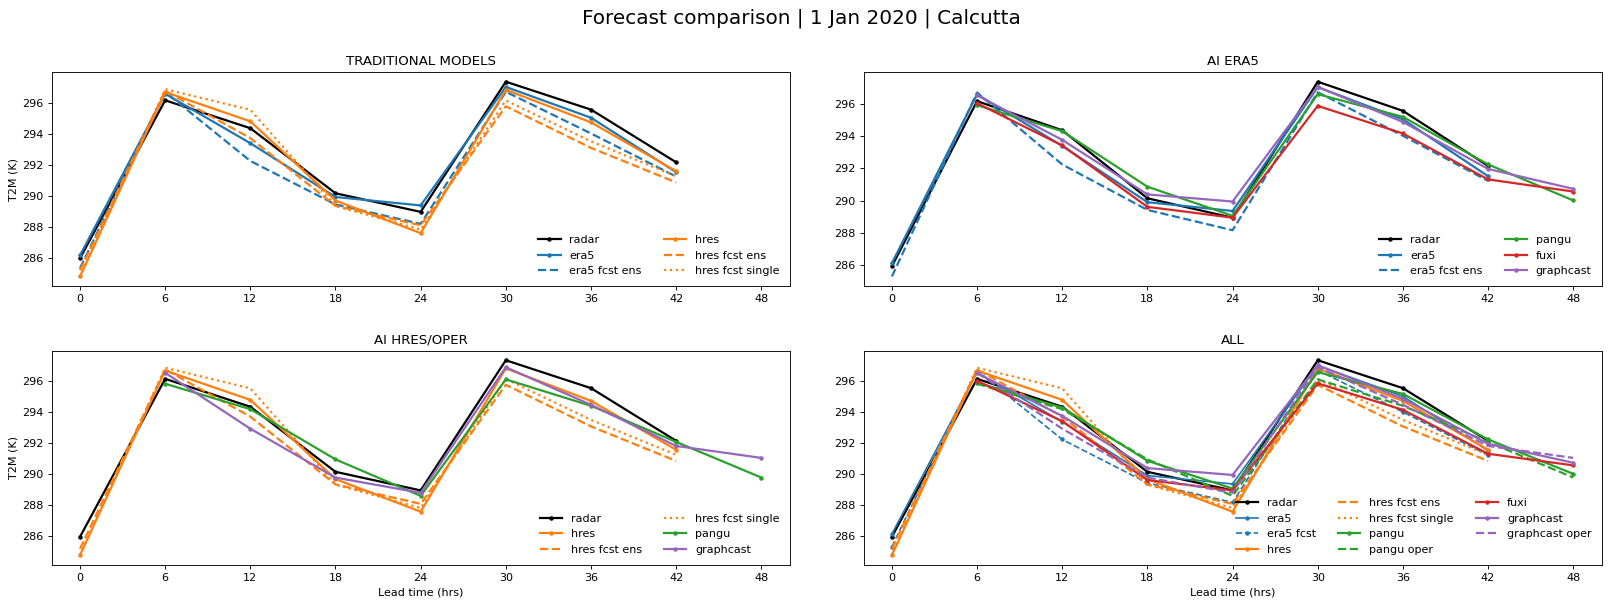

In [ ]:
# comparing forecasts for one day for ERA5 and ERA5 initialized AI models - validation using RADARs

lw=2
t = np.arange(0,48+6,6)
t.shape

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')

fig.suptitle('Forecast comparison | 1 Jan 2020 | Calcutta', size=18)
#fig.suptitle('Forecast comparison | 27 May 2020 | Delhi', size=18)

plt.subplot(221)

#plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '--', linewidth=lw, color='C0', label='era5 fcst ens')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')

plt.legend(frameon=False, ncol=2)
plt.title('TRADITIONAL MODELS')
plt.ylabel('T2M (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,54,6))


plt.subplot(222)

#plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '--', color='C0', linewidth=lw, label='era5 fcst ens')

plt.plot(t[1:], delhi_pangu, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_fuxi, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], delhi_graphcast, '.-', color='C4', linewidth=lw, label='graphcast')


plt.legend(frameon=False, ncol=2)
plt.title('AI ERA5')
plt.xlim(-2,50)
plt.xticks(np.arange(0,54,6))


plt.subplot(223)

#plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')


plt.plot(t[1:], delhi_panguoper, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_graphcastoper, '.-', color='C4', linewidth=lw, label='graphcast')


plt.legend(frameon=False, ncol=2)
plt.title('AI HRES/OPER')
plt.xlabel('Lead time (hrs)')
plt.ylabel('T2M (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,54,6))


plt.subplot(224)

#plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '.--', color='C0', label='era5 fcst')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')


plt.plot(t[1:], delhi_pangu, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_panguoper, '--', color='C2', linewidth=lw, label='pangu oper')
plt.plot(t[1:], delhi_fuxi, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], delhi_graphcast, '.-', color='C4', linewidth=lw, label='graphcast')
plt.plot(t[1:], delhi_graphcastoper, '--', color='C4', linewidth=lw, label='graphcast oper')

plt.xlabel('Lead time (hrs)')


plt.legend(frameon=False, ncol=3)
plt.title('ALL')
plt.xlim(-2,50)
plt.xticks(np.arange(0,54,6))

plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.savefig('drive/MyDrive/makdi/t2m_comparison_singleday_calcutta.png', bbox_inches='tight')
#plt.savefig('drive/MyDrive/makdi/t2m_comparison_singleday_delhi_may.png', bbox_inches='tight')

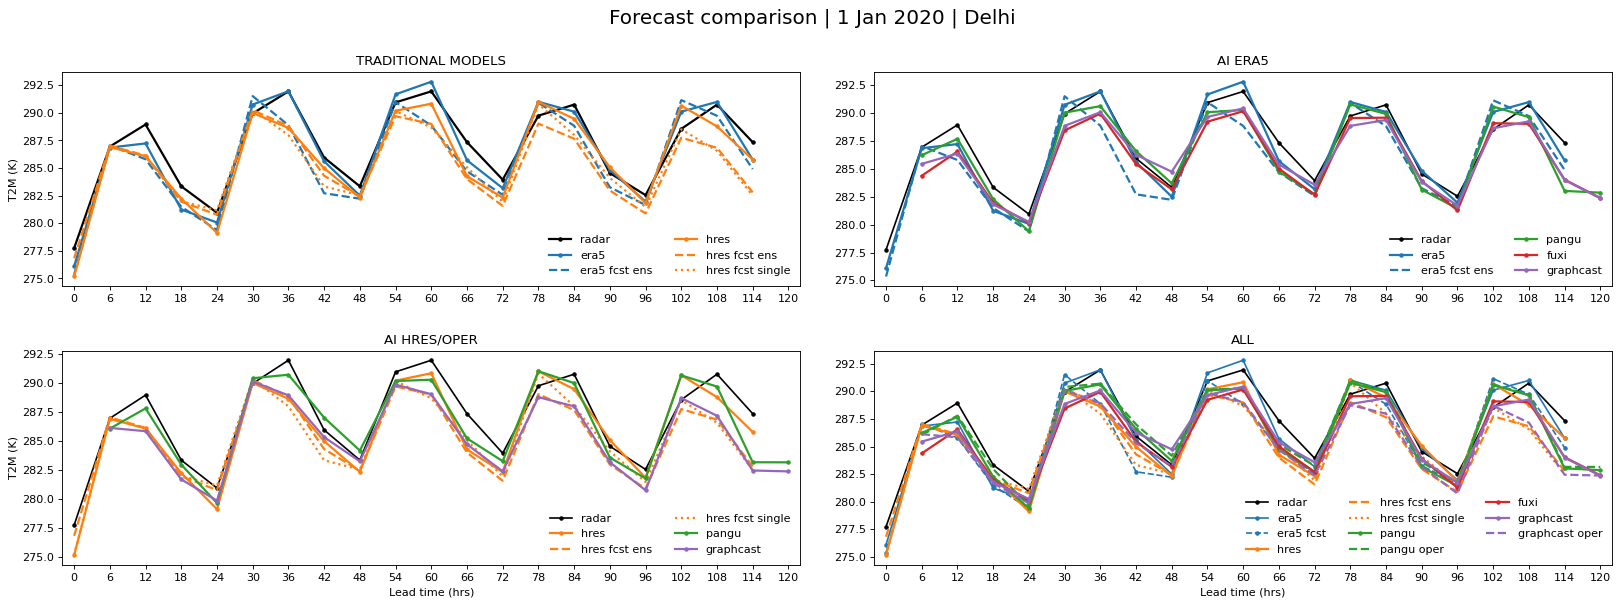

In [ ]:
# testing longer-term forecasts
# comparing forecasts for one day for ERA5 and ERA5 initialized AI models - validation using RADARs

lw=2
t = np.arange(0,120+6,6)
t.shape

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')

fig.suptitle('Forecast comparison | 1 Jan 2020 | Delhi', size=18)
#fig.suptitle('Forecast comparison | 27 May 2020 | Delhi', size=18)

plt.subplot(221)

plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '--', linewidth=lw, color='C0', label='era5 fcst ens')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')

plt.legend(frameon=False, ncol=2)
plt.title('TRADITIONAL MODELS')
plt.ylabel('T2M (K)')
plt.xlim(-2,122)
plt.xticks(np.arange(0,126,6))


plt.subplot(222)

plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '--', color='C0', linewidth=lw, label='era5 fcst ens')

plt.plot(t[1:], delhi_pangu, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_fuxi, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], delhi_graphcast, '.-', color='C4', linewidth=lw, label='graphcast')


plt.legend(frameon=False, ncol=2)
plt.title('AI ERA5')
plt.xlim(-2,122)
plt.xticks(np.arange(0,126,6))


plt.subplot(223)

plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')


plt.plot(t[1:], delhi_panguoper, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_graphcastoper, '.-', color='C4', linewidth=lw, label='graphcast')


plt.legend(frameon=False, ncol=2)
plt.title('AI HRES/OPER')
plt.xlabel('Lead time (hrs)')
plt.ylabel('T2M (K)')
plt.xlim(-2,122)
plt.xticks(np.arange(0,126,6))


plt.subplot(224)

plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '.--', color='C0', label='era5 fcst')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')


plt.plot(t[1:], delhi_pangu, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_panguoper, '--', color='C2', linewidth=lw, label='pangu oper')
plt.plot(t[1:], delhi_fuxi, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], delhi_graphcast, '.-', color='C4', linewidth=lw, label='graphcast')
plt.plot(t[1:], delhi_graphcastoper, '--', color='C4', linewidth=lw, label='graphcast oper')

plt.xlabel('Lead time (hrs)')


plt.legend(frameon=False, ncol=3)
plt.title('ALL')
plt.xlim(-2,122)
plt.xticks(np.arange(0,126,6))

plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.savefig('drive/MyDrive/makdi/t2m_comparison_singleday_delhi_5days.png', bbox_inches='tight')
#plt.savefig('drive/MyDrive/makdi/t2m_comparison_singleday_delhi_may.png', bbox_inches='tight')

In [ ]:
from metpy.calc import specific_humidity_from_dewpoint, relative_humidity_from_specific_humidity
from metpy.units import units

sphum = specific_humidity_from_dewpoint(pres*units.hPa, dwpt*units.degC).to('g/kg')

Text(0.5, 1.0, 'Conversion error is small')

<Figure size 2000x640 with 0 Axes>

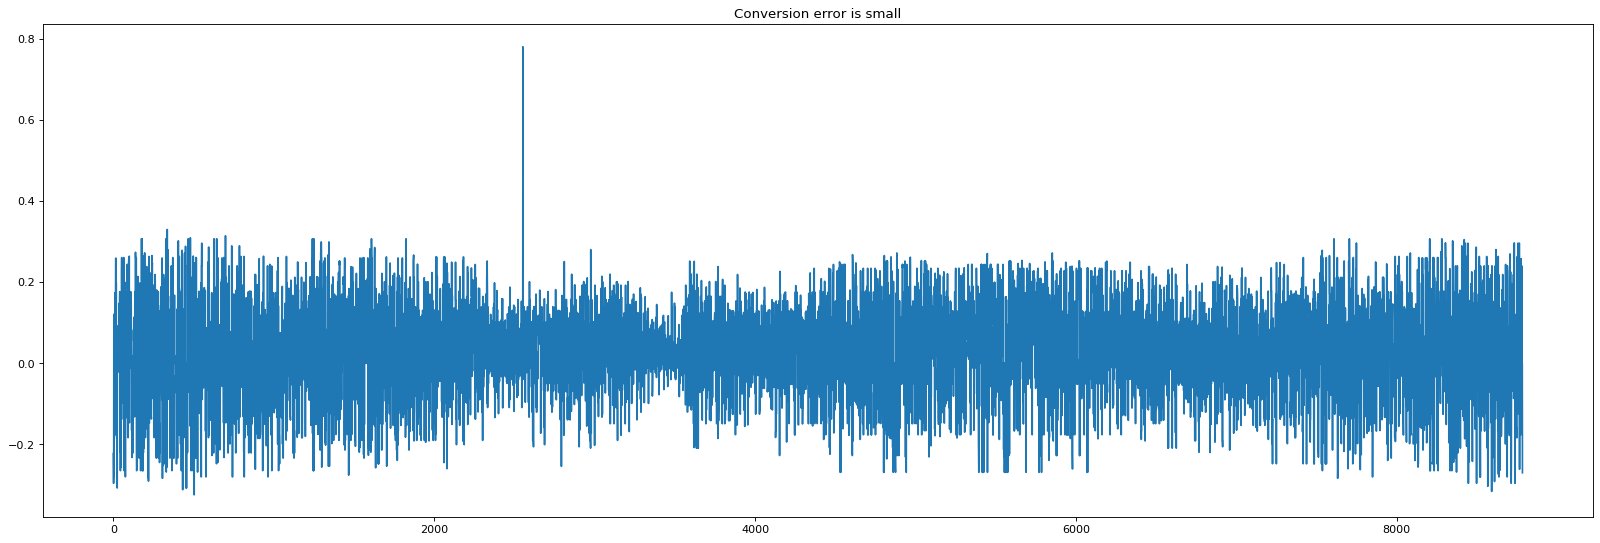

In [177]:
# Checked: RHUM -> SpHUM -> RHUM conversion is robust!
from metpy.calc import specific_humidity_from_dewpoint, relative_humidity_from_specific_humidity
from metpy.units import units

date = datetime(2020,1,1)

# for radar
start = date
end   = date + timedelta(days=366)

delhi       = Point(28.6439835,76.9280785)
radar_data  = Hourly(delhi,start,end) # daily


fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')
#plt.plot(radar_data.fetch()['wdir'][:])
dwpt = radar_data.fetch()['dwpt'][:].values
rhum = radar_data.fetch()['rhum'][:].values
temp = radar_data.fetch()['temp'][:].values
pres = radar_data.fetch()['pres'][:].values
wspd = radar_data.fetch()['wspd'][:].values
wdir = radar_data.fetch()['wdir'][:].values
uspd = -wspd*np.sin(np.pi*wdir/180.)
vspd = -wspd*np.cos(np.pi*wdir/180.)

sphum = specific_humidity_from_dewpoint(pres*units.hPa, dwpt*units.degC).to('g/kg')

rhum2 = relative_humidity_from_specific_humidity(pres*units.hPa, temp * units.degC, sphum).to('percent')

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')

plt.plot((rhum - rhum2.magnitude) )
plt.title('Conversion error is small')

#specific_humidity_from_dewpoint(988 * units.hPa, 15 * units.degC)
#relative_humidity_from_specific_humidity(1013.25 * units.hPa,
#                                         30 * units.degC, 18/1000).to('percent')

#plt.plot(rhum)

In [182]:
start = datetime(2020,1,1)
end   = datetime(2021,1,1)
time1=f'{start.year}-{str(start.month).zfill(2)}-{str(start.day).zfill(2)}T{str(start.hour).zfill(2)}:00:00.000000000'
time2=f'{end.year}-{str(end.month).zfill(2)}-{str(end.day).zfill(2)}T{str(end.hour).zfill(2)}:00:00.000000000'

#lat1 = data_era5['latitude'].values
#lat2 = data_hres['latitude'].values
#lon = data_era5['longitude'].values
#ix1=len(lon[lon<lon0])-1
#ix2=len(lon[lon<lon0])

# ERA5, Pangu, and PanguOper will use this
#iy1_desc=len(lat1[lat1>lat0])-1
#iy2_desc=len(lat1[lat1>lat0])

# Rest will use this
#iy1_asc=len(lat2[lat2<lat0])-1
#iy2_asc=len(lat2[lat2<lat0])

data_era5          = ds_era5.sel(time=slice(time1, time2), longitude=slice(lon0,lon0+0.25), latitude=slice(lat0,lat0-0.25))

u_era5 = data_era5['10m_u_component_of_wind'].values#[:,0,0]
v_era5 = data_era5['10m_v_component_of_wind'].values#[:,0,0]
t_era5 = data_era5['2m_temperature'].values#[:,0,0]



#temp_era5          = bilinear_interp( lon0, lat0, [ (lon[ix1], lat1[iy1_desc], u_era5[:,iy1_desc,ix1]),
#                                                      (lon[ix2], lat1[iy1_desc], u_era5[:,iy1_desc,ix2]),
#                                                      (lon[ix1], lat1[iy2_desc], u_era5[:,iy2_desc,ix1]),
#                                                      (lon[ix2], lat1[iy2_desc], u_era5[:,iy2_desc,ix2]) ] )

Text(0.5, 1.0, '10m v-wind')

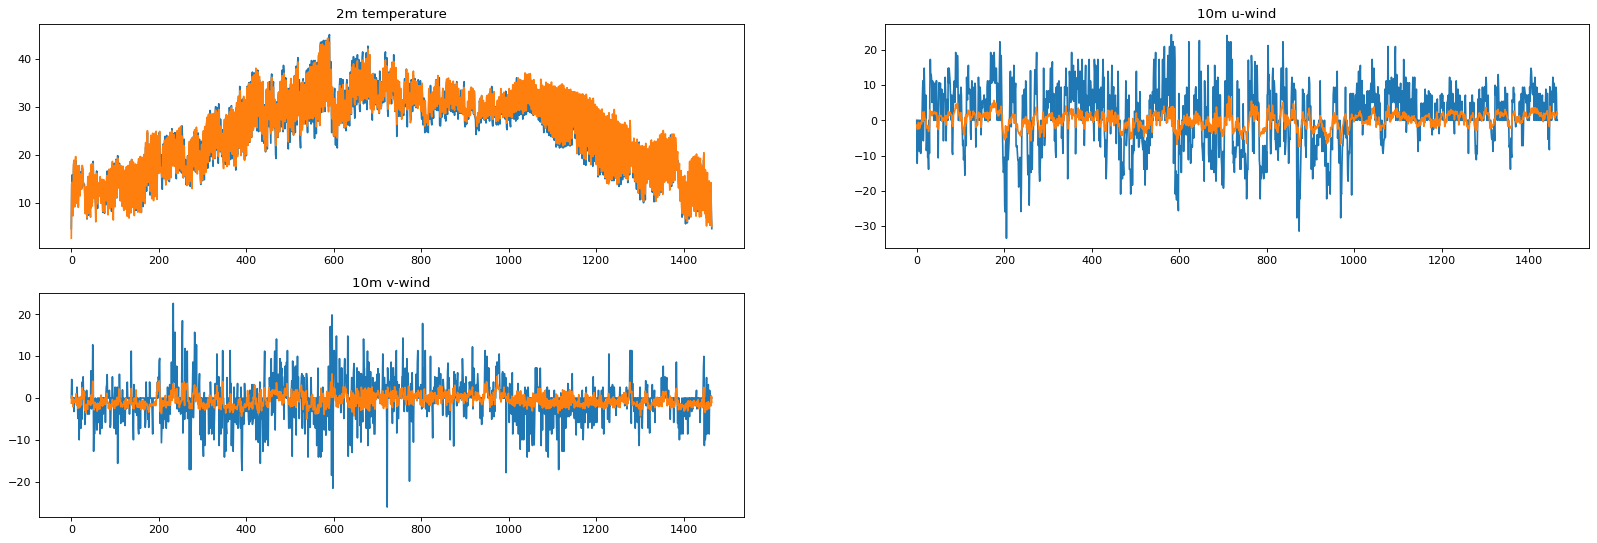

In [201]:
uspd = -wspd*np.sin(np.pi*wdir/180.)
vspd = -wspd*np.cos(np.pi*wdir/180.)

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(221)
plt.plot(temp[::6], label='radar')
plt.plot(t_era5[:,0,0]-273.16, label='ERA5')
plt.title('2m temperature')

plt.subplot(222)
plt.plot(uspd[::6], label='radar')
plt.plot(u_era5[:,0,0], label='ERA5')
plt.title('10m u-wind')

plt.subplot(223)
plt.plot(vspd[::6], label='radar')
plt.plot(v_era5[:,0,0], label='ERA5')
plt.title('10m v-wind')

Text(0.5, 1.0, '10m u-wind')

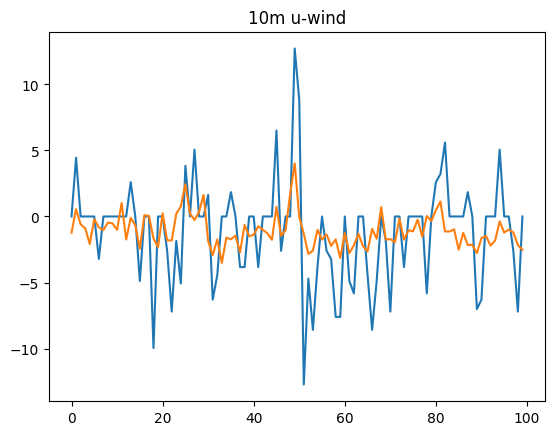

In [206]:
plt.plot(vspd[:600:6], label='radar')
plt.plot(v_era5[:100,0,0], label='ERA5')
plt.title('10m u-wind')

In [220]:
radar_data.fetch()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2020-01-01 00:00:00,4.6,3.6,93.0,NaN,NaN,0.0,0.0,NaN,1021.7,NaN,5.0
2020-01-01 01:00:00,6.0,5.0,93.0,NaN,NaN,0.0,0.0,NaN,1019.0,NaN,5.0
2020-01-01 02:00:00,6.0,5.0,93.0,NaN,NaN,0.0,0.0,NaN,1020.0,NaN,5.0
2020-01-01 03:00:00,5.4,4.5,94.0,NaN,NaN,70.0,9.4,NaN,1024.0,NaN,5.0
2020-01-01 04:00:00,9.0,7.0,87.0,NaN,NaN,80.0,9.4,NaN,1022.0,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 20:00:00,8.0,6.9,93.0,NaN,NaN,0.0,0.0,NaN,1017.0,NaN,5.0
2020-12-31 21:00:00,7.0,5.6,91.0,NaN,NaN,0.0,0.0,NaN,1019.1,NaN,5.0
2020-12-31 22:00:00,7.0,7.0,100.0,NaN,NaN,0.0,0.0,NaN,1017.0,NaN,5.0


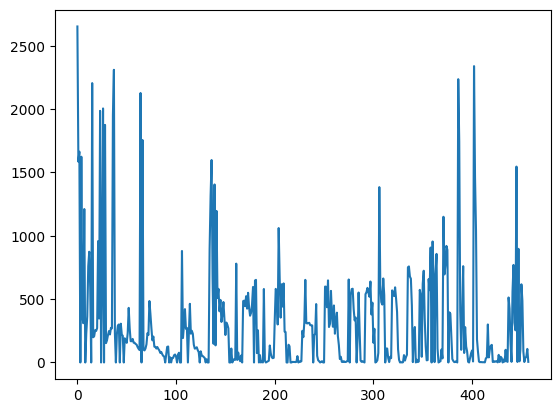

In [226]:
stations = Stations()
stations_list = stations.region('IN')

plt.plot(stations_list.fetch()['elevation'].values)